### Use Real Brain Tumor MRI Dataset

In [29]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
from sklearn.model_selection import StratifiedKFold
from cvxopt import matrix, solvers
import cv2

In [155]:
import kagglehub

path = kagglehub.dataset_download("masoudnickparvar/brain-tumor-mri-dataset")
glioma_path  = os.path.join(path, 'Testing', 'glioma')
notumor_path = os.path.join(path, 'Testing', 'notumor')

Sample image path: C:\Users\seren\.cache\kagglehub\datasets\masoudnickparvar\brain-tumor-mri-dataset\versions\1\Testing\meningioma\Te-meTr_0000.jpg


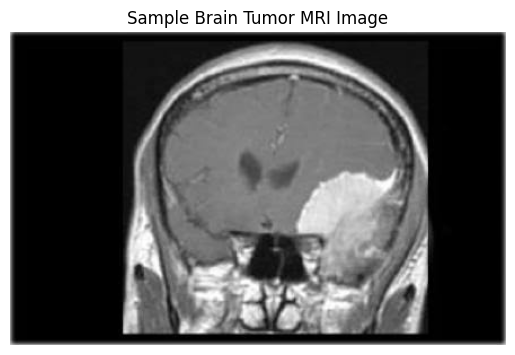

In [153]:
import os
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt

sample_image_path = None
for file in os.listdir(glioma_path):
    if file.endswith('.jpg'):
        sample_image_path = os.path.join(glioma_path, file)
        break

if sample_image_path:
    print(f"Sample image path: {sample_image_path}")
else:
    print("No .jpg files found in the glioma directory.")

img = Image.open(sample_image_path)
plt.imshow(img)
plt.axis('off')
plt.title('Sample Brain Tumor MRI Image')
plt.show()

In [178]:
def load_and_preprocess_data(glioma_path, pituitary_path, meningioma_path, notumor_path):
    tumor_images = [np.array(Image.open(os.path.join(glioma_path, f)).resize((64, 64)).convert('L')).flatten() 
                    for f in os.listdir(glioma_path) if f.endswith('.jpg')]
    notumor_images = [np.array(Image.open(os.path.join(notumor_path, f)).resize((64, 64)).convert('L')).flatten() 
                      for f in os.listdir(notumor_path) if f.endswith('.jpg')]
    
    X = np.array(tumor_images + notumor_images)
    y = np.array([1] * len(tumor_images) + [-1] * len(notumor_images))
    
    return X, y

X, y = load_and_preprocess_data(glioma_path, pituitary_path, meningioma_path, notumor_path)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [167]:
def rbf_kernel(x1, x2, gamma):
    return np.exp(-gamma * np.linalg.norm(x1 - x2)**2)

def polynomial_kernel(x1, x2, degree=3):
    scale = 1.0 / (x1.shape[0])  
    return (scale * np.dot(x1, x2) + 1.0) ** degree


def train_svm(X_train, y_train, kernel_func, kernel_param, C):
    n_samples = X_train.shape[0]
    K = np.array([[kernel_func(X_train[i], X_train[j], kernel_param) for j in range(n_samples)] for i in range(n_samples)])
    
    P = matrix(np.outer(y_train, y_train) * K)
    q = matrix(-np.ones(n_samples))
    A = matrix(y_train.astype(float), (1, n_samples))
    b = matrix(0.0)
    G = matrix(np.vstack((-np.eye(n_samples), np.eye(n_samples))))
    h = matrix(np.hstack((np.zeros(n_samples), C * np.ones(n_samples))))
    
    solvers.options['show_progress'] = False
    solution = solvers.qp(P, q, G, h, A, b)
    alphas = np.ravel(solution['x'])
    
    support_vectors = alphas > 1e-5
    b_values = [y_train[i] - np.sum(alphas * y_train * K[i]) for i in range(n_samples) if support_vectors[i]]
    b = np.mean(b_values)
    
    return alphas, b, support_vectors

def decision_function(X_train, y_train, alphas, X_test, b, kernel_func, kernel_param):
    return np.array([
        np.sum(alphas * y_train * np.array([kernel_func(x_train, x_test, kernel_param) for x_train in X_train]))
        for x_test in X_test
    ]) + b

In [182]:
from tqdm import tqdm
from sklearn.model_selection import StratifiedKFold

def tune_hyperparameters(X_train, y_train, kernel_func, param_grid, n_splits=5):
    best_params, best_score = None, 0
    n = len(param_grid)
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)
    
    for i in tqdm(range(n)):
        params = param_grid[i]
        try:
            cv_scores = []
            for train_idx, val_idx in skf.split(X_train, y_train):
                X_train_cv, X_val_cv = X_train[train_idx], X_train[val_idx]
                y_train_cv, y_val_cv = y_train[train_idx], y_train[val_idx]
                
                alphas, b, _ = train_svm(X_train_cv, y_train_cv, kernel_func, params['kernel_param'], params['C'])
                decision_values = decision_function(X_train_cv, y_train_cv, alphas, X_val_cv, b, kernel_func, params['kernel_param'])
                accuracy = np.mean(np.sign(decision_values) == y_val_cv)
                cv_scores.append(accuracy)
            
            mean_cv_score = np.mean(cv_scores)
            if mean_cv_score > best_score:
                best_score = mean_cv_score
                best_params = params
            print(mean_cv_score, params)
                
        except Exception as e:
            print(f"Error with parameters {params}: {str(e)}")
            continue
            
    if best_params is None:
        raise ValueError("No valid parameters found during tuning")
        
    return best_params, best_score


In [202]:
rbf_param_grid = [{'kernel_param': gamma, 'C': C} for gamma in [0.001, 0.1, 0.5, 1, 2, 5] for C in [0.01, 0.1, 1, 10, 100]]
best_rbf_params, best_rbf_score = tune_hyperparameters(X_train_scaled, y_train, rbf_kernel, rbf_param_grid)

  3%|██▊                                                                                | 1/30 [01:25<41:20, 85.52s/it]

0.6453697850821744 {'kernel_param': 0.001, 'C': 0.01}


  7%|█████▌                                                                             | 2/30 [02:51<40:02, 85.82s/it]

0.8510745891276864 {'kernel_param': 0.001, 'C': 0.1}


 10%|████████▎                                                                          | 3/30 [04:09<37:00, 82.23s/it]

0.9361883691529709 {'kernel_param': 0.001, 'C': 1}


 13%|███████████                                                                        | 4/30 [05:05<31:07, 71.84s/it]

0.9485619469026549 {'kernel_param': 0.001, 'C': 10}


 17%|█████████████▊                                                                     | 5/30 [06:01<27:31, 66.07s/it]

0.9485619469026549 {'kernel_param': 0.001, 'C': 100}


 20%|████████████████▌                                                                  | 6/30 [07:05<26:12, 65.53s/it]

0.5904235145385588 {'kernel_param': 0.1, 'C': 0.01}


 23%|███████████████████▎                                                               | 7/30 [08:04<24:15, 63.27s/it]

0.5904235145385588 {'kernel_param': 0.1, 'C': 0.1}


 27%|██████████████████████▏                                                            | 8/30 [09:04<22:46, 62.13s/it]

0.5939791403286978 {'kernel_param': 0.1, 'C': 1}


 30%|████████████████████████▌                                                         | 9/30 [13:04<41:14, 117.85s/it]

0.5939791403286978 {'kernel_param': 0.1, 'C': 10}


 33%|███████████████████████████                                                      | 10/30 [14:38<36:50, 110.55s/it]

0.5939791403286978 {'kernel_param': 0.1, 'C': 100}


 37%|██████████████████████████████                                                    | 11/30 [15:43<30:32, 96.47s/it]

0.5904235145385588 {'kernel_param': 0.5, 'C': 0.01}


 40%|████████████████████████████████▊                                                 | 12/30 [16:49<26:08, 87.17s/it]

0.5904235145385588 {'kernel_param': 0.5, 'C': 0.1}


 43%|███████████████████████████████████▌                                              | 13/30 [18:02<23:30, 82.97s/it]

0.5939791403286978 {'kernel_param': 0.5, 'C': 1}


 47%|██████████████████████████████████████▎                                           | 14/30 [19:21<21:48, 81.76s/it]

0.5939791403286978 {'kernel_param': 0.5, 'C': 10}


 50%|█████████████████████████████████████████                                         | 15/30 [20:50<21:00, 84.02s/it]

0.5939791403286978 {'kernel_param': 0.5, 'C': 100}


 53%|███████████████████████████████████████████▋                                      | 16/30 [22:13<19:31, 83.66s/it]

0.5904235145385588 {'kernel_param': 1, 'C': 0.01}


 57%|██████████████████████████████████████████████▍                                   | 17/30 [23:47<18:47, 86.71s/it]

0.5904235145385588 {'kernel_param': 1, 'C': 0.1}


 60%|█████████████████████████████████████████████████▏                                | 18/30 [25:06<16:54, 84.53s/it]

0.5939791403286978 {'kernel_param': 1, 'C': 1}


 63%|███████████████████████████████████████████████████▉                              | 19/30 [26:02<13:54, 75.83s/it]

0.5939791403286978 {'kernel_param': 1, 'C': 10}


 67%|██████████████████████████████████████████████████████▋                           | 20/30 [26:55<11:31, 69.16s/it]

0.5939791403286978 {'kernel_param': 1, 'C': 100}


 70%|█████████████████████████████████████████████████████████▍                        | 21/30 [27:51<09:46, 65.19s/it]

0.5904235145385588 {'kernel_param': 2, 'C': 0.01}


 73%|████████████████████████████████████████████████████████████▏                     | 22/30 [28:55<08:37, 64.68s/it]

0.5904235145385588 {'kernel_param': 2, 'C': 0.1}


 77%|██████████████████████████████████████████████████████████████▊                   | 23/30 [29:58<07:29, 64.24s/it]

0.5939791403286978 {'kernel_param': 2, 'C': 1}


 80%|█████████████████████████████████████████████████████████████████▌                | 24/30 [31:35<07:24, 74.03s/it]

0.5939791403286978 {'kernel_param': 2, 'C': 10}


 83%|████████████████████████████████████████████████████████████████████▎             | 25/30 [32:43<06:01, 72.37s/it]

0.5939791403286978 {'kernel_param': 2, 'C': 100}


 87%|███████████████████████████████████████████████████████████████████████           | 26/30 [34:13<05:10, 77.59s/it]

0.5904235145385588 {'kernel_param': 5, 'C': 0.01}


 90%|█████████████████████████████████████████████████████████████████████████▊        | 27/30 [35:12<03:36, 72.02s/it]

0.5904235145385588 {'kernel_param': 5, 'C': 0.1}


 93%|████████████████████████████████████████████████████████████████████████████▌     | 28/30 [36:18<02:20, 70.23s/it]

0.5939791403286978 {'kernel_param': 5, 'C': 1}


 97%|███████████████████████████████████████████████████████████████████████████████▎  | 29/30 [38:07<01:21, 81.82s/it]

0.5939791403286978 {'kernel_param': 5, 'C': 10}


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [39:39<00:00, 79.31s/it]

0.5939791403286978 {'kernel_param': 5, 'C': 100}


In [192]:
poly_param_grid = [{'kernel_param': degree, 'C': C} for degree in [1, 2, 3, 4, 5] for C in [0.001, 0.1, 1, 10, 100]]
best_poly_params, best_poly_score = tune_hyperparameters(X_train_scaled, y_train, polynomial_kernel, poly_param_grid)

  4%|███▎                                                                               | 1/25 [01:19<31:46, 79.45s/it]

0.8352718078381794 {'kernel_param': 1, 'C': 0.001}


  8%|██████▋                                                                            | 2/25 [02:54<33:55, 88.51s/it]

0.9166877370417194 {'kernel_param': 1, 'C': 0.1}


 12%|█████████▉                                                                         | 3/25 [03:54<27:39, 75.43s/it]

0.9557048040455121 {'kernel_param': 1, 'C': 1}


 16%|█████████████▎                                                                     | 4/25 [04:40<22:26, 64.10s/it]

0.9733723135271808 {'kernel_param': 1, 'C': 10}


 20%|████████████████▌                                                                  | 5/25 [05:31<19:44, 59.21s/it]

0.9716024020227559 {'kernel_param': 1, 'C': 100}


 24%|███████████████████▉                                                               | 6/25 [06:21<17:48, 56.24s/it]

0.8422882427307206 {'kernel_param': 2, 'C': 0.001}


 28%|███████████████████████▏                                                           | 7/25 [07:06<15:44, 52.48s/it]

0.943299620733249 {'kernel_param': 2, 'C': 0.1}


 32%|██████████████████████████▌                                                        | 8/25 [07:48<13:52, 48.95s/it]

0.9645385587863464 {'kernel_param': 2, 'C': 1}


 36%|█████████████████████████████▉                                                     | 9/25 [08:30<12:32, 47.04s/it]

0.975158027812895 {'kernel_param': 2, 'C': 10}


 40%|████████████████████████████████▊                                                 | 10/25 [09:12<11:22, 45.50s/it]

0.975158027812895 {'kernel_param': 2, 'C': 100}


 44%|████████████████████████████████████                                              | 11/25 [10:00<10:47, 46.24s/it]

0.8547250316055625 {'kernel_param': 3, 'C': 0.001}


 48%|███████████████████████████████████████▎                                          | 12/25 [10:49<10:10, 46.96s/it]

0.9557048040455121 {'kernel_param': 3, 'C': 0.1}


 52%|██████████████████████████████████████████▋                                       | 13/25 [11:38<09:30, 47.58s/it]

0.9733881163084701 {'kernel_param': 3, 'C': 1}


 56%|█████████████████████████████████████████████▉                                    | 14/25 [12:25<08:40, 47.31s/it]

0.9786978508217447 {'kernel_param': 3, 'C': 10}


 60%|█████████████████████████████████████████████████▏                                | 15/25 [13:11<07:49, 46.99s/it]

0.9786978508217447 {'kernel_param': 3, 'C': 100}


 64%|████████████████████████████████████████████████████▍                             | 16/25 [14:04<07:18, 48.69s/it]

0.8512010113780025 {'kernel_param': 4, 'C': 0.001}


 68%|███████████████████████████████████████████████████████▊                          | 17/25 [15:00<06:48, 51.10s/it]

0.9610145385587865 {'kernel_param': 4, 'C': 0.1}


 72%|███████████████████████████████████████████████████████████                       | 18/25 [15:48<05:51, 50.22s/it]

0.9786978508217447 {'kernel_param': 4, 'C': 1}


 76%|██████████████████████████████████████████████████████████████▎                   | 19/25 [16:33<04:50, 48.49s/it]

0.9786978508217447 {'kernel_param': 4, 'C': 10}


 80%|█████████████████████████████████████████████████████████████████▌                | 20/25 [17:19<03:58, 47.77s/it]

0.9786978508217447 {'kernel_param': 4, 'C': 100}


 84%|████████████████████████████████████████████████████████████████████▉             | 21/25 [18:05<03:08, 47.11s/it]

0.854709228824273 {'kernel_param': 5, 'C': 0.001}


 88%|████████████████████████████████████████████████████████████████████████▏         | 22/25 [18:51<02:20, 46.80s/it]

0.9698640960809103 {'kernel_param': 5, 'C': 0.1}


 92%|███████████████████████████████████████████████████████████████████████████▍      | 23/25 [19:37<01:33, 46.79s/it]

0.9804835651074588 {'kernel_param': 5, 'C': 1}


 96%|██████████████████████████████████████████████████████████████████████████████▋   | 24/25 [20:24<00:46, 46.87s/it]

0.9804835651074588 {'kernel_param': 5, 'C': 10}


100%|██████████████████████████████████████████████████████████████████████████████████| 25/25 [21:10<00:00, 50.82s/it]

0.9804835651074588 {'kernel_param': 5, 'C': 100}


In [205]:
print(f"Best RBF parameters: {best_rbf_params}, Score: {best_rbf_score:.4f}")
print(f"Best Polynomial parameters: {best_poly_params}, Score: {best_poly_score:.4f}")

Best RBF parameters: {'kernel_param': 0.001, 'C': 10}, Score: 0.9486
Best Polynomial parameters: {'kernel_param': 5, 'C': 1}, Score: 0.9805


In [207]:
rbf_alphas, rbf_b, _ = train_svm(X_train_scaled, y_train, rbf_kernel, best_rbf_params['kernel_param'], best_rbf_params['C'])
poly_alphas, poly_b, _ = train_svm(X_train_scaled, y_train, polynomial_kernel, best_poly_params['kernel_param'], best_poly_params['C'])

In [208]:
def evaluate_model(X_train, y_train, X_test, y_test, kernel_func, kernel_param, alphas, b):
    decision_values = decision_function(X_train, y_train, alphas, X_test, b, kernel_func, kernel_param)
    y_pred = np.sign(decision_values)
    
    accuracy = np.mean(y_pred == y_test)
    cm = confusion_matrix(y_test, y_pred)
    report = classification_report(y_test, y_pred)
    fpr, tpr, _ = roc_curve(y_test, decision_values)
    roc_auc = auc(fpr, tpr)
    
    return accuracy, cm, report, fpr, tpr, roc_auc

rbf_results = evaluate_model(X_train_scaled, y_train, X_test_scaled, y_test, rbf_kernel, best_rbf_params['kernel_param'], rbf_alphas, rbf_b)
poly_results = evaluate_model(X_train_scaled, y_train, X_test_scaled, y_test, polynomial_kernel, best_poly_params['kernel_param'], poly_alphas, poly_b)

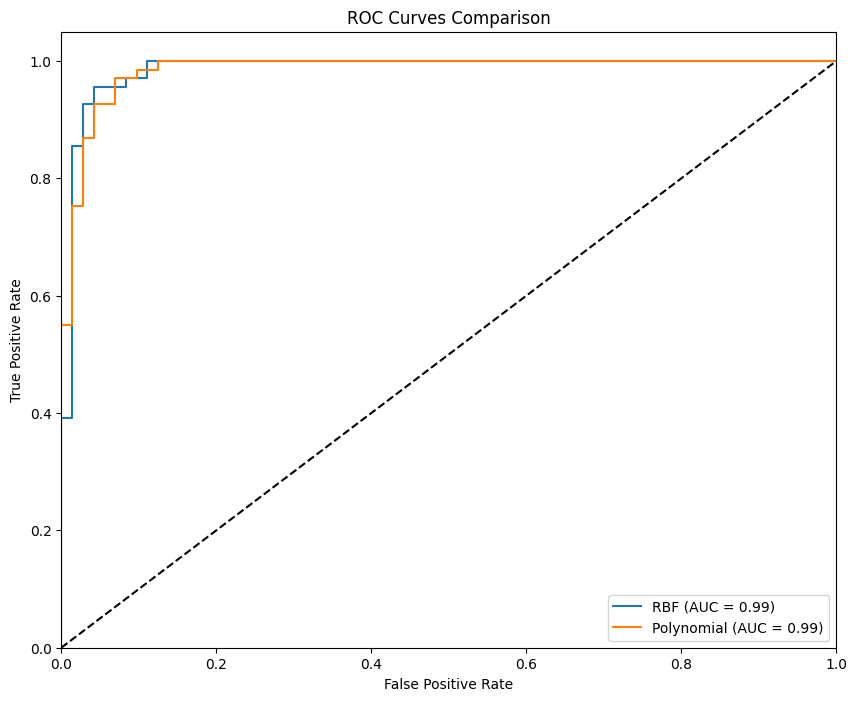

In [226]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, roc_curve, auc
from sklearn.model_selection import learning_curve
from sklearn.svm import SVC
from sklearn.model_selection import learning_curve

def plot_roc_curves(rbf_results, poly_results):
    plt.figure(figsize=(10, 8))
    for kernel, results in [("RBF", rbf_results), ("Polynomial", poly_results)]:
        plt.plot(results[3], results[4], label=f'{kernel} (AUC = {results[5]:.2f})')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curves Comparison')
    plt.legend(loc="lower right")
    plt.show()

plot_roc_curves(rbf_results, poly_results)

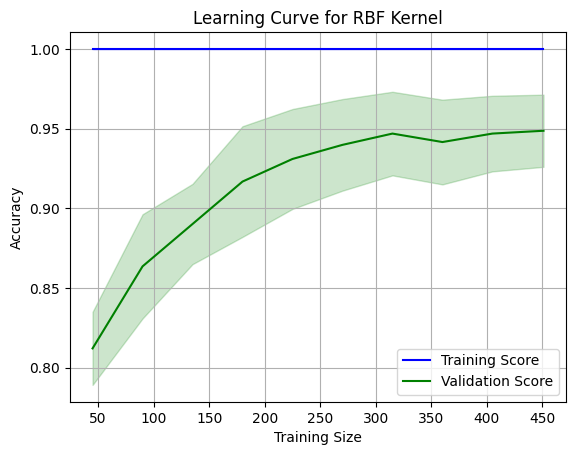

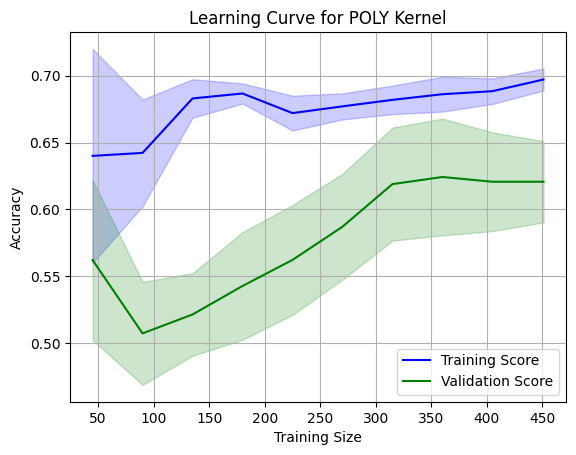

In [228]:
def plot_learning_curves(X, y, kernel_func, param, C):
    kernel = 'rbf' if kernel_func == rbf_kernel else 'poly'
    svc = SVC(kernel=kernel, C=C, gamma=param if kernel == 'rbf' else 'auto', degree=param if kernel == 'poly' else 3)
    train_sizes, train_scores, val_scores = learning_curve(
        svc, X, y, cv=5, scoring='accuracy', n_jobs=-1, train_sizes=np.linspace(0.1, 1.0, 10)
    )
    train_mean = np.mean(train_scores, axis=1)
    train_std = np.std(train_scores, axis=1)
    val_mean = np.mean(val_scores, axis=1)
    val_std = np.std(val_scores, axis=1)

    plt.figure()
    plt.plot(train_sizes, train_mean, label='Training Score', color='blue')
    plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, color='blue', alpha=0.2)
    plt.plot(train_sizes, val_mean, label='Validation Score', color='green')
    plt.fill_between(train_sizes, val_mean - val_std, val_mean + val_std, color='green', alpha=0.2)

    plt.title(f'Learning Curve for {kernel.upper()} Kernel')
    plt.xlabel('Training Size')
    plt.ylabel('Accuracy')
    plt.legend(loc='best')
    plt.grid()
    plt.show()

plot_learning_curves(X_train_scaled, y_train, rbf_kernel, best_rbf_params['kernel_param'], best_rbf_params['C'])
plot_learning_curves(X_train_scaled, y_train, polynomial_kernel, best_poly_params['kernel_param'], best_poly_params['C'])

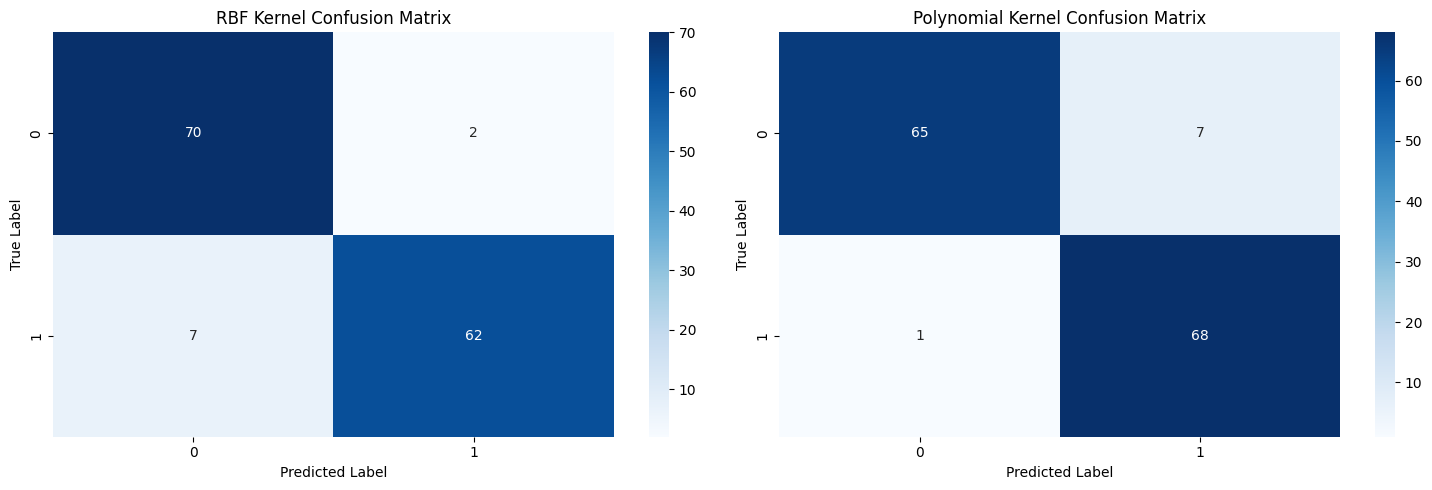

In [230]:
def plot_confusion_matrices(rbf_results, poly_results):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    sns.heatmap(rbf_results[1], annot=True, fmt='d', cmap='Blues', ax=ax1)
    ax1.set_title('RBF Kernel Confusion Matrix')
    ax1.set_xlabel('Predicted Label')
    ax1.set_ylabel('True Label')
    
    sns.heatmap(poly_results[1], annot=True, fmt='d', cmap='Blues', ax=ax2)
    ax2.set_title('Polynomial Kernel Confusion Matrix')
    ax2.set_xlabel('Predicted Label')
    ax2.set_ylabel('True Label')
    plt.tight_layout()
    plt.show()
    
plot_confusion_matrices(rbf_results, poly_results)

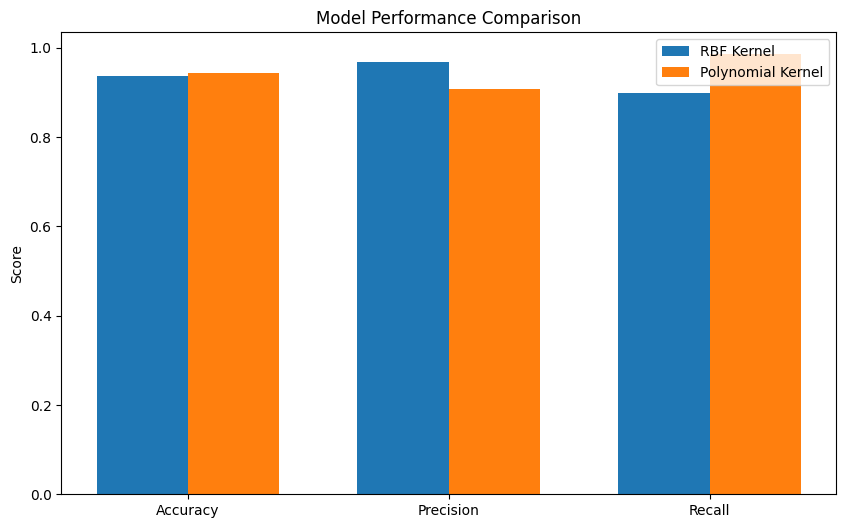

In [232]:
def plot_model_comparison(rbf_results, poly_results):
    metrics = ['Accuracy', 'Precision', 'Recall']
    rbf_scores = [rbf_results[0], rbf_results[1][1,1]/(rbf_results[1][1,1] + rbf_results[1][0,1]), 
                  rbf_results[1][1,1]/(rbf_results[1][1,1] + rbf_results[1][1,0])]
    poly_scores = [poly_results[0], poly_results[1][1,1]/(poly_results[1][1,1] + poly_results[1][0,1]),
                   poly_results[1][1,1]/(poly_results[1][1,1] + poly_results[1][1,0])]
    
    x = np.arange(len(metrics))
    width = 0.35
    
    fig, ax = plt.subplots(figsize=(10, 6))
    ax.bar(x - width/2, rbf_scores, width, label='RBF Kernel')
    ax.bar(x + width/2, poly_scores, width, label='Polynomial Kernel')
    ax.set_ylabel('Score')
    ax.set_title('Model Performance Comparison')
    ax.set_xticks(x)
    ax.set_xticklabels(metrics)
    ax.legend()
    plt.show()
    
plot_model_comparison(rbf_results, poly_results)

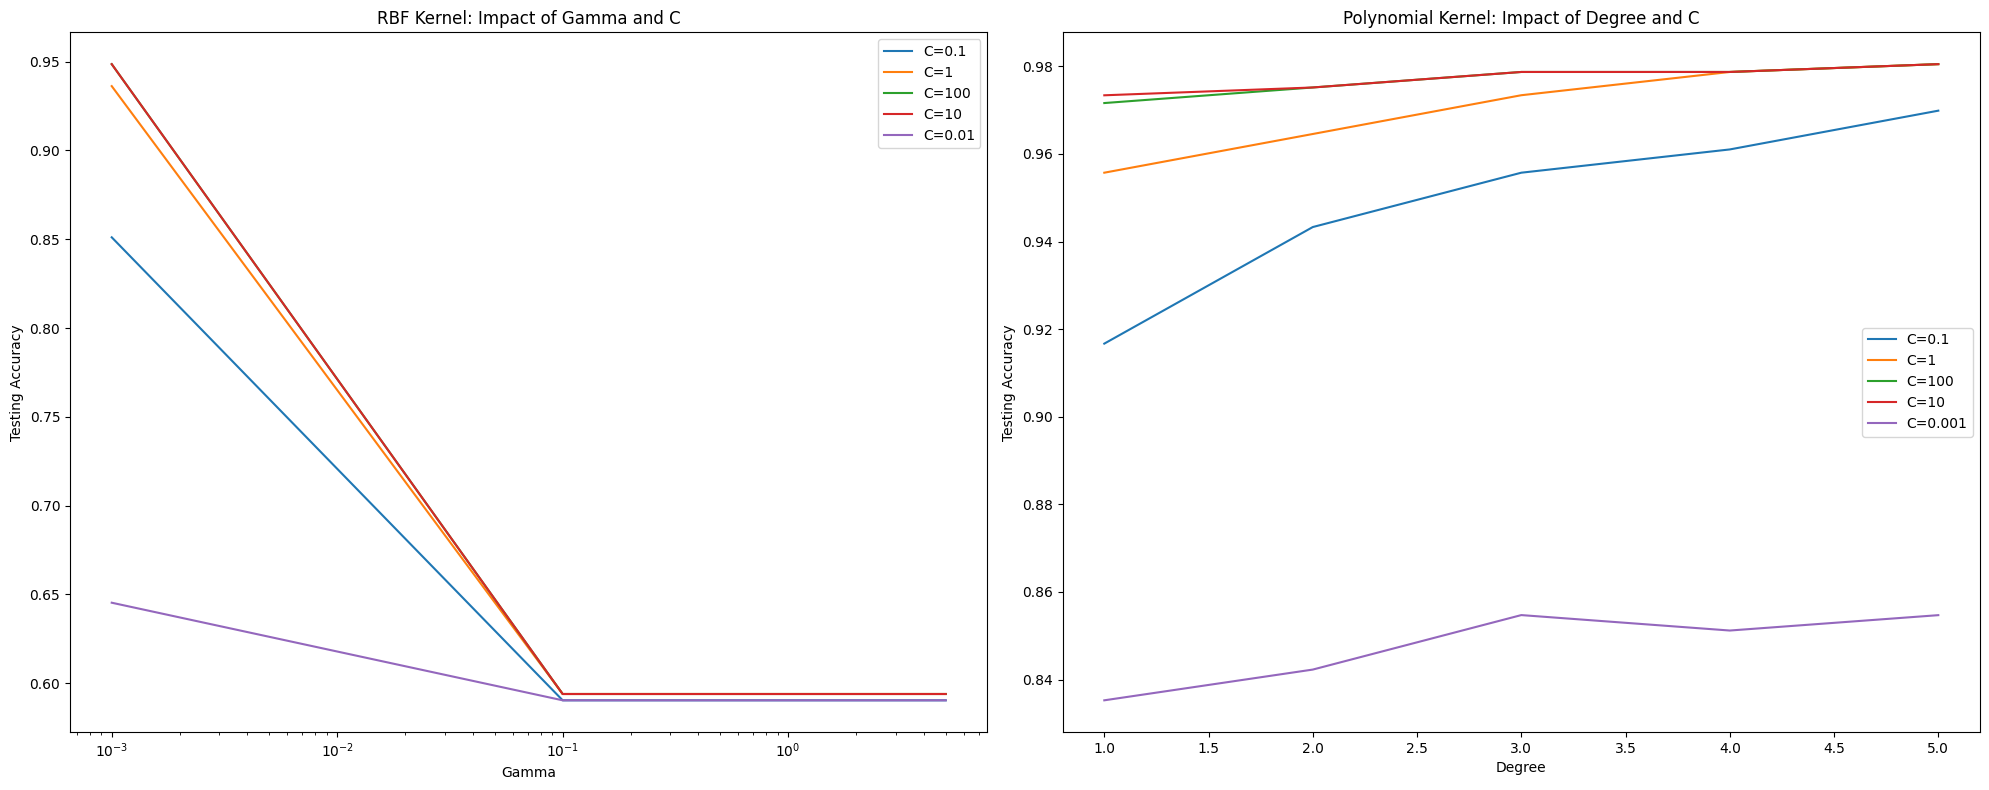

In [270]:
def extract_results():
    rbf_raw = [
        (0.6453697850821744, {'kernel_param': 0.001, 'C': 0.01}),
        (0.8510745891276864, {'kernel_param': 0.001, 'C': 0.1}),
        (0.9361883691529709, {'kernel_param': 0.001, 'C': 1}),
        (0.9485619469026549, {'kernel_param': 0.001, 'C': 10}),
        (0.9485619469026549, {'kernel_param': 0.001, 'C': 100}),
        (0.5904235145385588, {'kernel_param': 0.1, 'C': 0.01}),
        (0.5904235145385588, {'kernel_param': 0.1, 'C': 0.1}),
        (0.5939791403286978, {'kernel_param': 0.1, 'C': 1}),
        (0.5939791403286978, {'kernel_param': 0.1, 'C': 10}),
        (0.5939791403286978, {'kernel_param': 0.1, 'C': 100}),
        (0.5904235145385588, {'kernel_param': 0.5, 'C': 0.01}),
        (0.5904235145385588, {'kernel_param': 0.5, 'C': 0.1}),
        (0.5939791403286978, {'kernel_param': 0.5, 'C': 1}),
        (0.5939791403286978, {'kernel_param': 0.5, 'C': 10}),
        (0.5939791403286978, {'kernel_param': 0.5, 'C': 100}),
        (0.5904235145385588, {'kernel_param': 1, 'C': 0.01}),
        (0.5904235145385588, {'kernel_param': 1, 'C': 0.1}),
        (0.5939791403286978, {'kernel_param': 1, 'C': 1}),
        (0.5939791403286978, {'kernel_param': 1, 'C': 10}),
        (0.5939791403286978, {'kernel_param': 1, 'C': 100}),
        (0.5904235145385588, {'kernel_param': 2, 'C': 0.01}),
        (0.5904235145385588, {'kernel_param': 2, 'C': 0.1}),
        (0.5939791403286978, {'kernel_param': 2, 'C': 1}),
        (0.5939791403286978, {'kernel_param': 2, 'C': 10}),
        (0.5939791403286978, {'kernel_param': 2, 'C': 100}),
        (0.5904235145385588, {'kernel_param': 5, 'C': 0.01}),
        (0.5904235145385588, {'kernel_param': 5, 'C': 0.1}),
        (0.5939791403286978, {'kernel_param': 5, 'C': 1}),
        (0.5939791403286978, {'kernel_param': 5, 'C': 10}),
        (0.5939791403286978, {'kernel_param': 5, 'C': 100}),
    ]
    
    poly_raw = [
        (0.8352718078381794, {'kernel_param': 1, 'C': 0.001}),
        (0.9166877370417194, {'kernel_param': 1, 'C': 0.1}),
        (0.9557048040455121, {'kernel_param': 1, 'C': 1}),
        (0.9733723135271808, {'kernel_param': 1, 'C': 10}),
        (0.9716024020227559, {'kernel_param': 1, 'C': 100}),
        (0.8422882427307206, {'kernel_param': 2, 'C': 0.001}),
        (0.943299620733249, {'kernel_param': 2, 'C': 0.1}),
        (0.9645385587863464, {'kernel_param': 2, 'C': 1}),
        (0.975158027812895, {'kernel_param': 2, 'C': 10}),
        (0.975158027812895, {'kernel_param': 2, 'C': 100}),
        (0.8547250316055625, {'kernel_param': 3, 'C': 0.001}),
        (0.9557048040455121, {'kernel_param': 3, 'C': 0.1}),
        (0.9733881163084701, {'kernel_param': 3, 'C': 1}),
        (0.9786978508217447, {'kernel_param': 3, 'C': 10}),
        (0.9786978508217447, {'kernel_param': 3, 'C': 100}),
        (0.8512010113780025, {'kernel_param': 4, 'C': 0.001}),
        (0.9610145385587865, {'kernel_param': 4, 'C': 0.1}),
        (0.9786978508217447, {'kernel_param': 4, 'C': 1}),
        (0.9786978508217447, {'kernel_param': 4, 'C': 10}),
        (0.9786978508217447, {'kernel_param': 4, 'C': 100}),
        (0.854709228824273, {'kernel_param': 5, 'C': 0.001}),
        (0.9698640960809103, {'kernel_param': 5, 'C': 0.1}),
        (0.9804835651074588, {'kernel_param': 5, 'C': 1}),
        (0.9804835651074588, {'kernel_param': 5, 'C': 10}),
        (0.9804835651074588, {'kernel_param': 5, 'C': 100}),
    ]

    
    rbf_results = [
        ('rbf_kernel', data['kernel_param'], data['C'], None, accuracy)
        for accuracy, data in rbf_raw
    ]
    
    poly_results = [
        ('polynomial_kernel', data['kernel_param'], data['C'], None, accuracy)
        for accuracy, data in poly_raw
    ]
    return rbf_results + poly_results

results = extract_results()


def plot_parameter_analysis(results):
    rbf_results = [r for r in results if r[0] == 'rbf_kernel']
    poly_results = [r for r in results if r[0] == 'polynomial_kernel']
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))
    
    for C in set([r[2] for r in rbf_results]):
        data = [(r[1], r[4]) for r in rbf_results if r[2] == C]
        ax1.plot(*zip(*data), label=f'C={C}')
    ax1.set_xscale('log')
    ax1.set_xlabel('Gamma')
    ax1.set_ylabel('Testing Accuracy')
    ax1.set_title('RBF Kernel: Impact of Gamma and C')
    ax1.legend()
    
    for C in set([r[2] for r in poly_results]):
        data = [(r[1], r[4]) for r in poly_results if r[2] == C]
        ax2.plot(*zip(*data), label=f'C={C}')
    ax2.set_xlabel('Degree')
    ax2.set_ylabel('Testing Accuracy')
    ax2.set_title('Polynomial Kernel: Impact of Degree and C')
    ax2.legend()
    
    plt.tight_layout()
    plt.show()

plot_parameter_analysis(results)

### Use Simulated Dataset

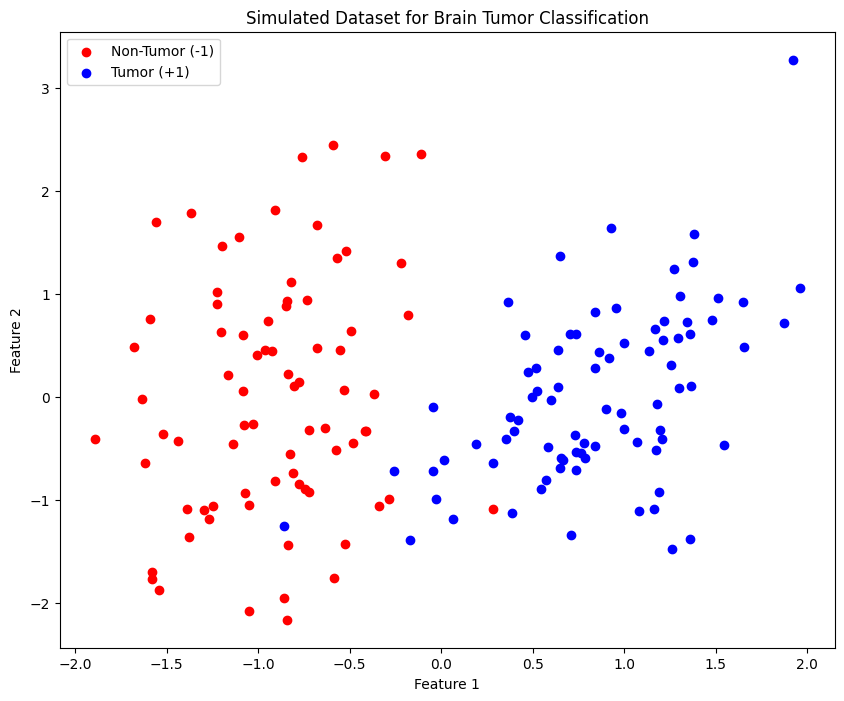

Training labels: [-1  1]
Testing labels: [-1  1]


In [11]:
X, y = make_classification(
    n_samples=200, 
    n_features=2, 
    n_informative=2, 
    n_redundant=0,
    n_clusters_per_class=1, 
    class_sep=2, 
    random_state=42
)
scaler = StandardScaler()
X = scaler.fit_transform(X)
y = np.where(y == 0, -1, 1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

plt.figure(figsize=(10, 8))
plt.scatter(X_train_scaled[y_train == -1, 0], X_train_scaled[y_train == -1, 1], color="red", label="Non-Tumor (-1)")
plt.scatter(X_train_scaled[y_train == 1, 0], X_train_scaled[y_train == 1, 1], color="blue", label="Tumor (+1)")
plt.title("Simulated Dataset for Brain Tumor Classification")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.legend()
plt.show()

print(f"Training labels: {np.unique(y_train)}")
print(f"Testing labels: {np.unique(y_test)}")

In [12]:
import numpy as np
from cvxopt import matrix, solvers

def rbf_kernel(x1, x2, gamma):
    return np.exp(-gamma * np.linalg.norm(x1 - x2)**2)

def polynomial_kernel(x1, x2, degree=3):
    return (np.dot(x1, x2) + 1) ** degree

def train_svm(X_train, y_train, kernel_func, kernel_param, C):
    n_samples = X_train.shape[0]
    K = np.array([[kernel_func(X_train[i], X_train[j], kernel_param) for j in range(n_samples)] for i in range(n_samples)])
    
    P = matrix(np.outer(y_train, y_train) * K)
    q = matrix(-np.ones(n_samples))
    A = matrix(y_train.astype(float), (1, n_samples))
    b = matrix(0.0)
    G = matrix(np.vstack((-np.eye(n_samples), np.eye(n_samples))))
    h = matrix(np.hstack((np.zeros(n_samples), C * np.ones(n_samples))))
    
    solvers.options['show_progress'] = False
    solution = solvers.qp(P, q, G, h, A, b)
    alphas = np.ravel(solution['x'])
    
    support_vectors = alphas > 1e-5
    b_values = [y_train[i] - np.sum(alphas * y_train * K[i]) for i in range(n_samples) if support_vectors[i]]
    b = np.mean(b_values)
    
    return alphas, b, support_vectors

def decision_function(X_train, y_train, alphas, X_test, b, kernel_func, kernel_param):
    decision_values = np.zeros(len(X_test))
    for i, x in enumerate(X_test):
        decision_values[i] = sum(
            alphas[j] * y_train[j] * kernel_func(X_train[j], x, kernel_param)
            for j in range(len(X_train))
        ) + b
    return decision_values

In [13]:
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, roc_curve, auc

def tune_hyperparameters(X_train, y_train, kernel_func, param_grid):
    best_params = None
    best_score = 0
    
    for params in param_grid:
        scores = []
        skf = StratifiedKFold(n_splits=5)
        for train_idx, val_idx in skf.split(X_train, y_train):
            X_train_cv, X_val_cv = X_train[train_idx], X_train[val_idx]
            y_train_cv, y_val_cv = y_train[train_idx], y_train[val_idx]
            
            alphas, b, _ = train_svm(X_train_cv, y_train_cv, kernel_func, params['kernel_param'], params['C'])
            val_decision = decision_function(X_train_cv, y_train_cv, alphas, X_val_cv, b, kernel_func, params['kernel_param'])
            val_pred = np.sign(val_decision)
            scores.append(accuracy_score(y_val_cv, val_pred))
        
        mean_score = np.mean(scores)
        if mean_score > best_score:
            best_score = mean_score
            best_params = params
    
    return best_params, best_score

def evaluate_model(X_train, y_train, X_test, y_test, kernel_func, kernel_param, C):
    alphas, b, _ = train_svm(X_train, y_train, kernel_func, kernel_param, C)
    test_decision = decision_function(X_train, y_train, alphas, X_test, b, kernel_func, kernel_param)
    y_pred = np.sign(test_decision)
    
    accuracy = accuracy_score(y_test, y_pred)
    precision, recall, _, _ = precision_recall_fscore_support(y_test, y_pred, average='binary')
    
    fpr, tpr, _ = roc_curve(y_test, test_decision)
    roc_auc = auc(fpr, tpr)
    
    return accuracy, precision, recall, roc_auc, fpr, tpr

In [14]:
import matplotlib.pyplot as plt

def plot_decision_boundary(X, y, kernel_func, kernel_param, alphas, b):
    xx, yy = np.meshgrid(np.linspace(X[:, 0].min() - 1, X[:, 0].max() + 1, 200),
                         np.linspace(X[:, 1].min() - 1, X[:, 1].max() + 1, 200))
    Z = decision_function(X, y, alphas, np.c_[xx.ravel(), yy.ravel()], b, kernel_func, kernel_param)
    Z = Z.reshape(xx.shape)
    
    plt.figure(figsize=(10, 8))
    plt.contourf(xx, yy, Z, levels=50, cmap=plt.cm.RdYlBu, alpha=0.8)
    plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.RdYlBu, edgecolors='black')
    plt.title("SVM Decision Boundary")
    plt.xlabel("Feature 1")
    plt.ylabel("Feature 2")
    plt.show()

def plot_roc_curve(fpr, tpr, roc_auc):
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc="lower right")
    plt.show()

Training SVM with rbf_kernel, param=0.05, C=0.1


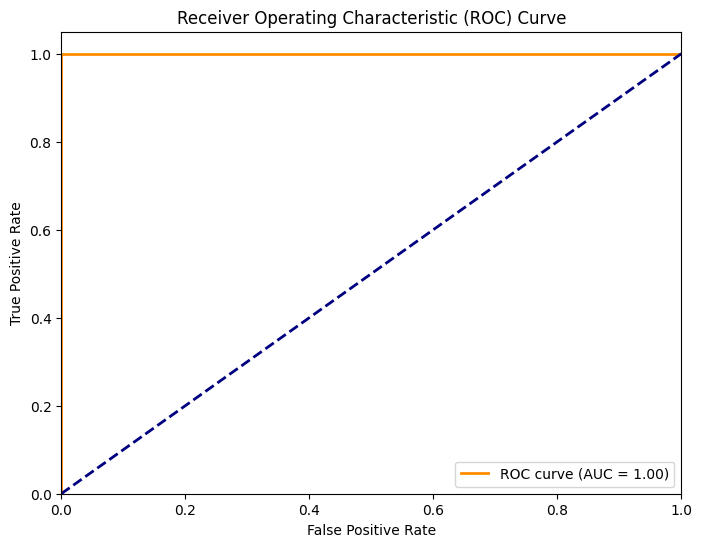

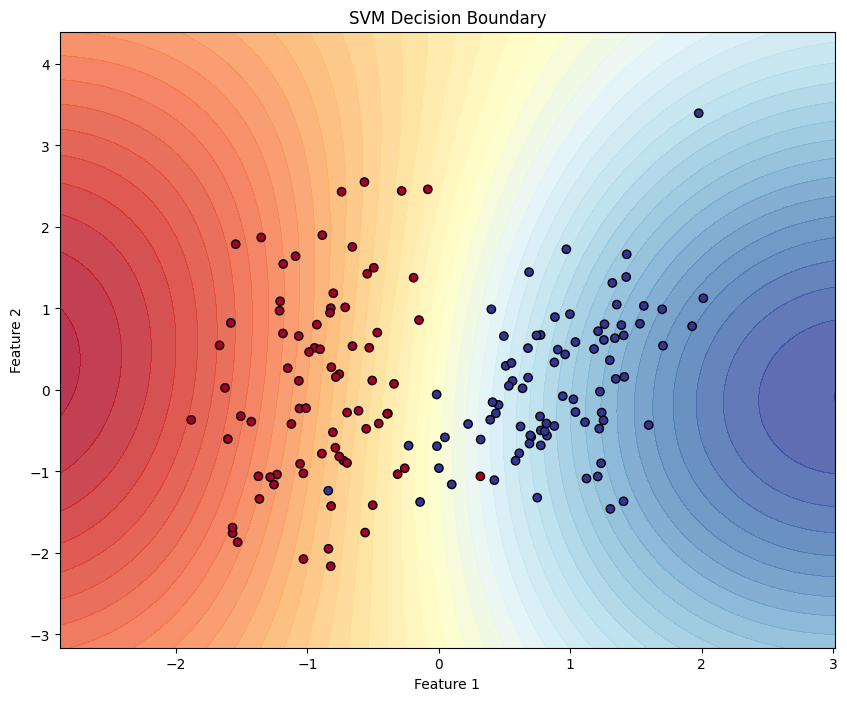

Training SVM with rbf_kernel, param=0.05, C=0.5


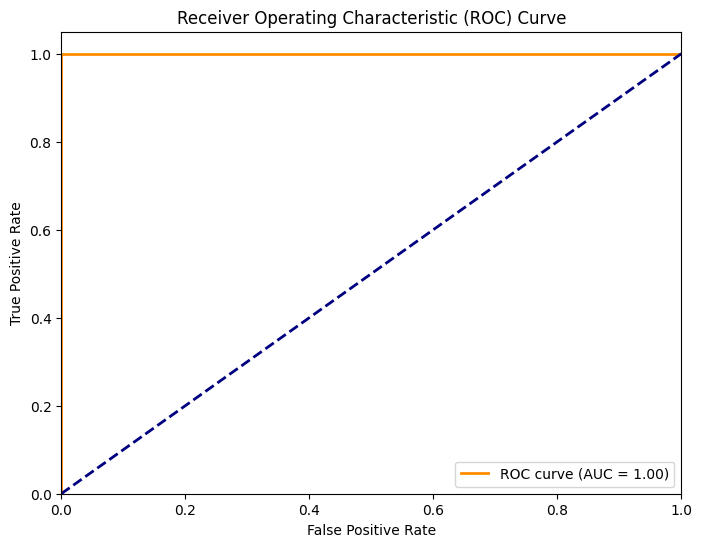

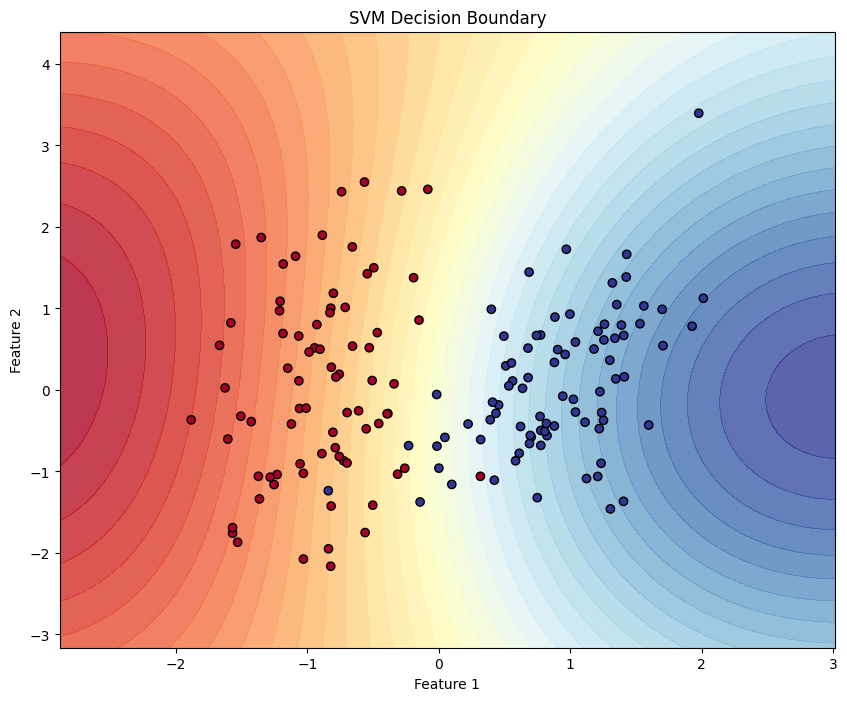

Training SVM with rbf_kernel, param=0.05, C=1


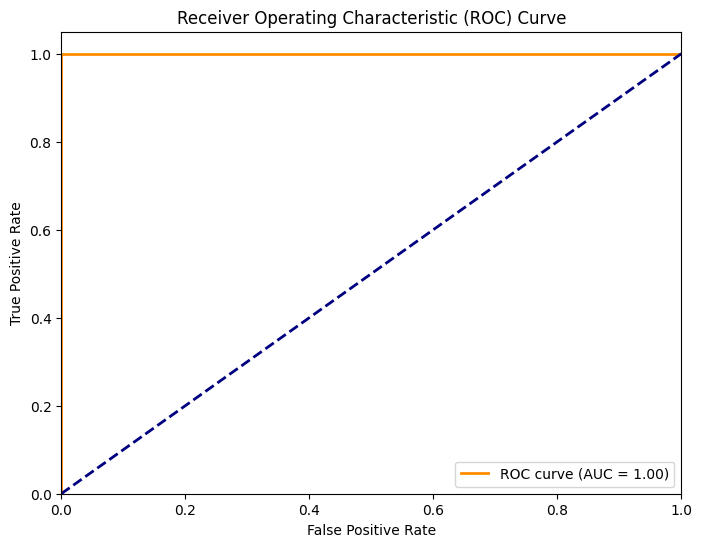

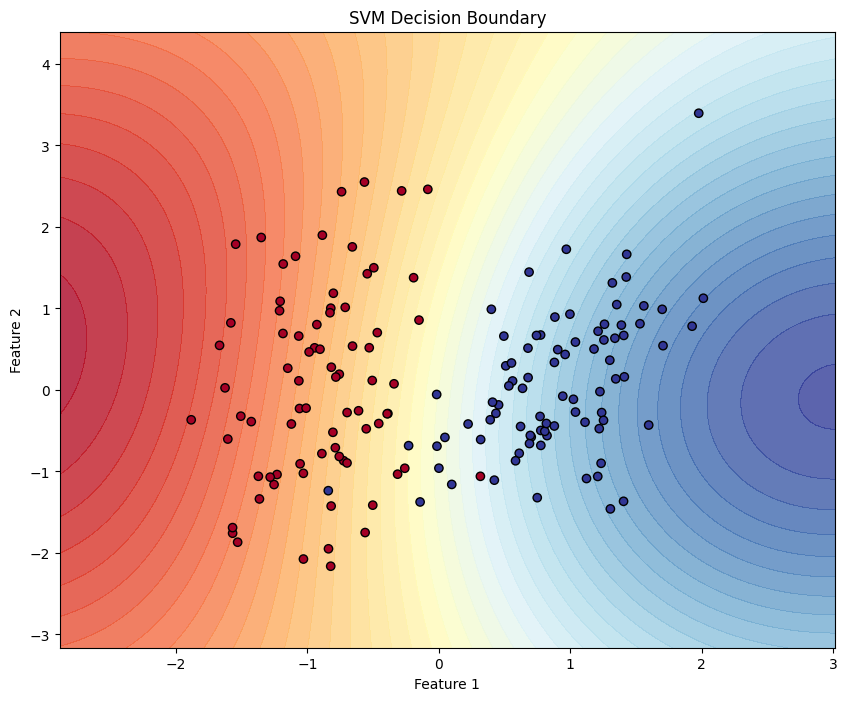

Training SVM with rbf_kernel, param=0.05, C=5


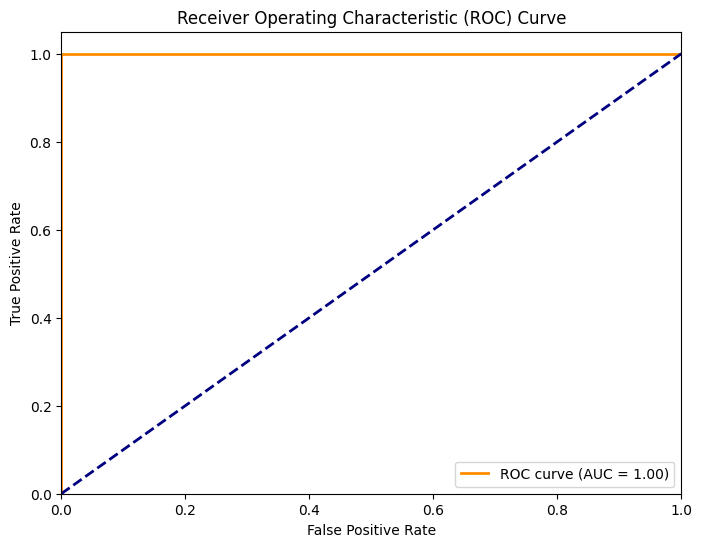

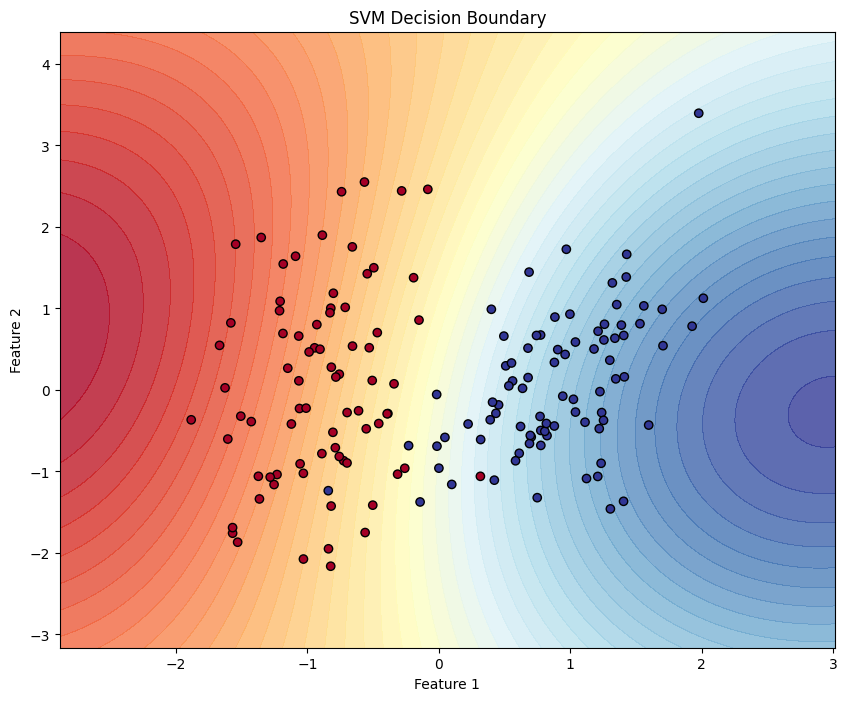

Training SVM with rbf_kernel, param=0.05, C=10


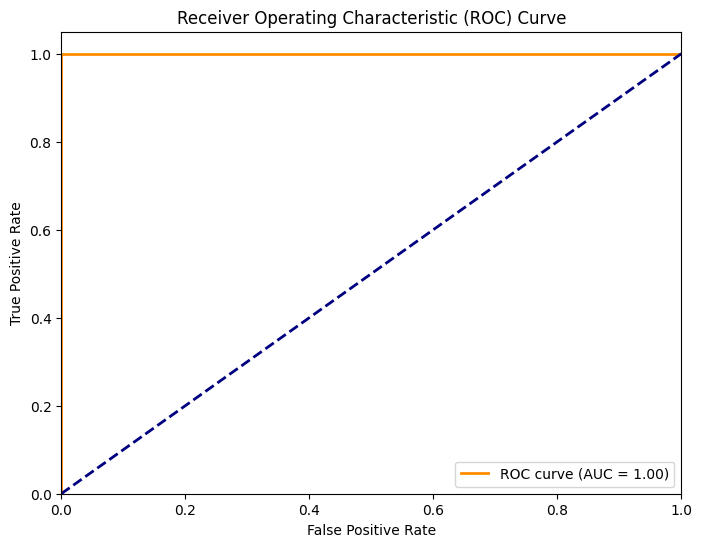

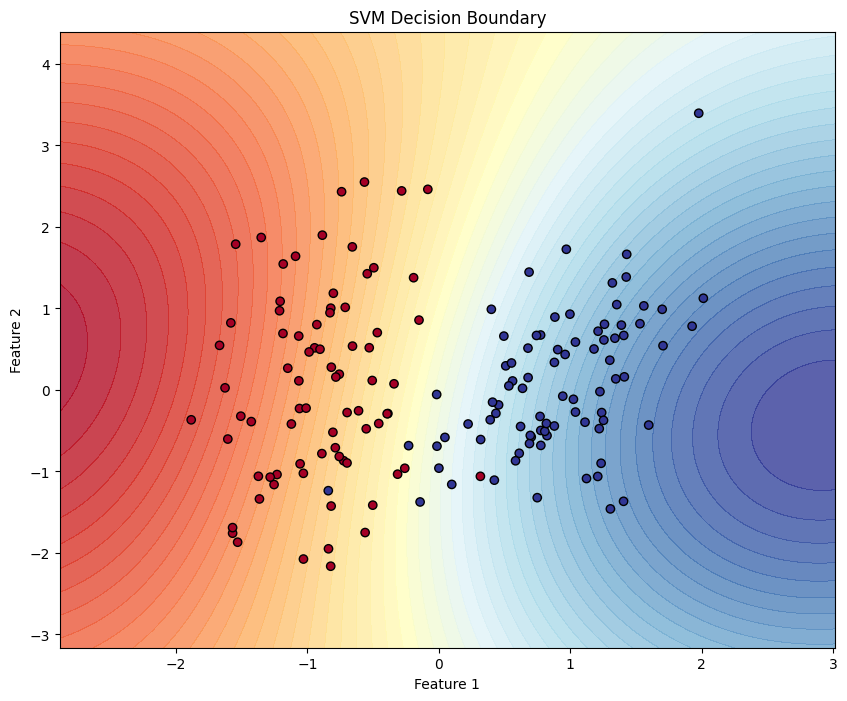

Training SVM with rbf_kernel, param=0.1, C=0.1


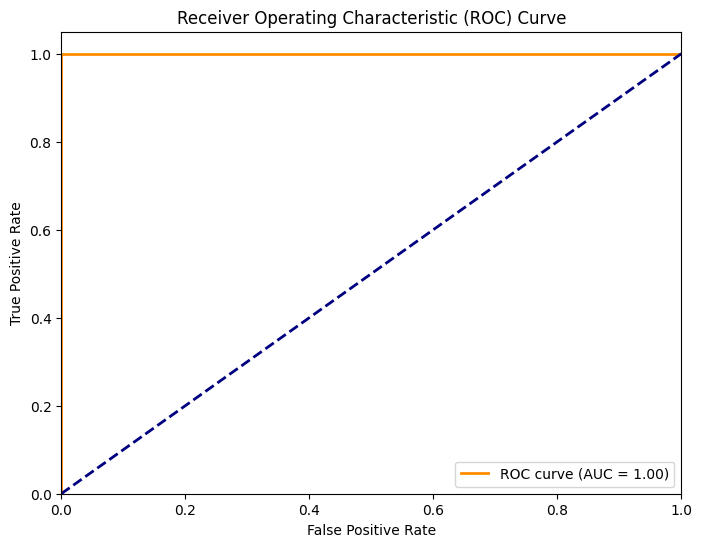

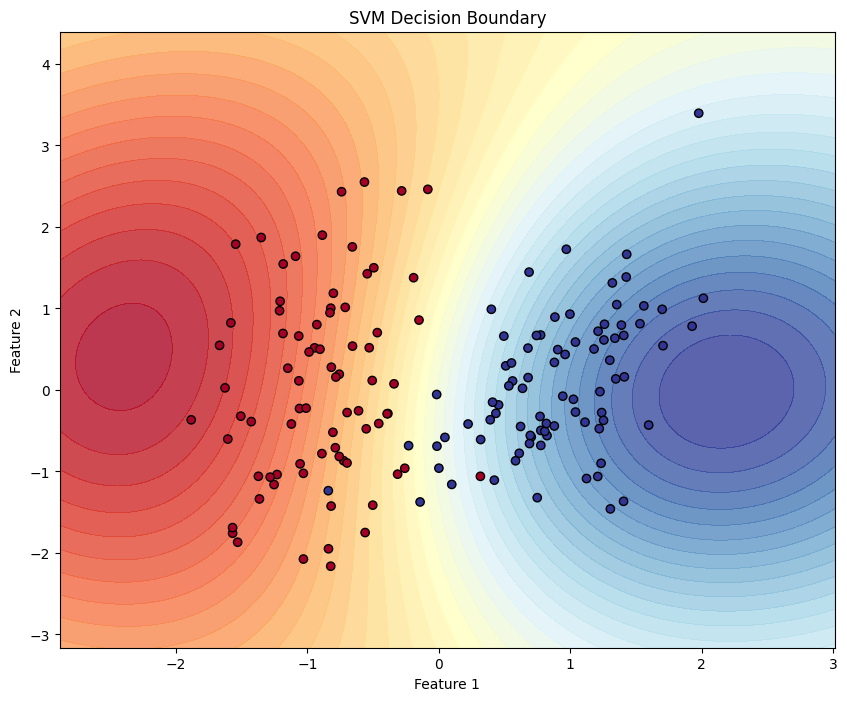

Training SVM with rbf_kernel, param=0.1, C=0.5


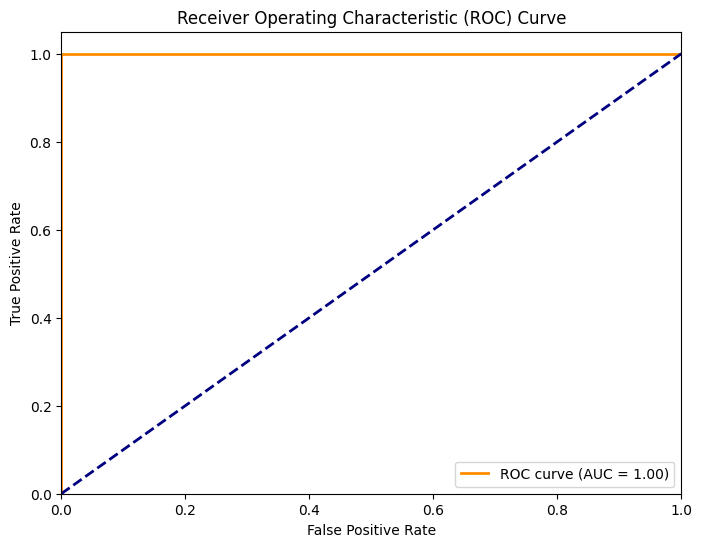

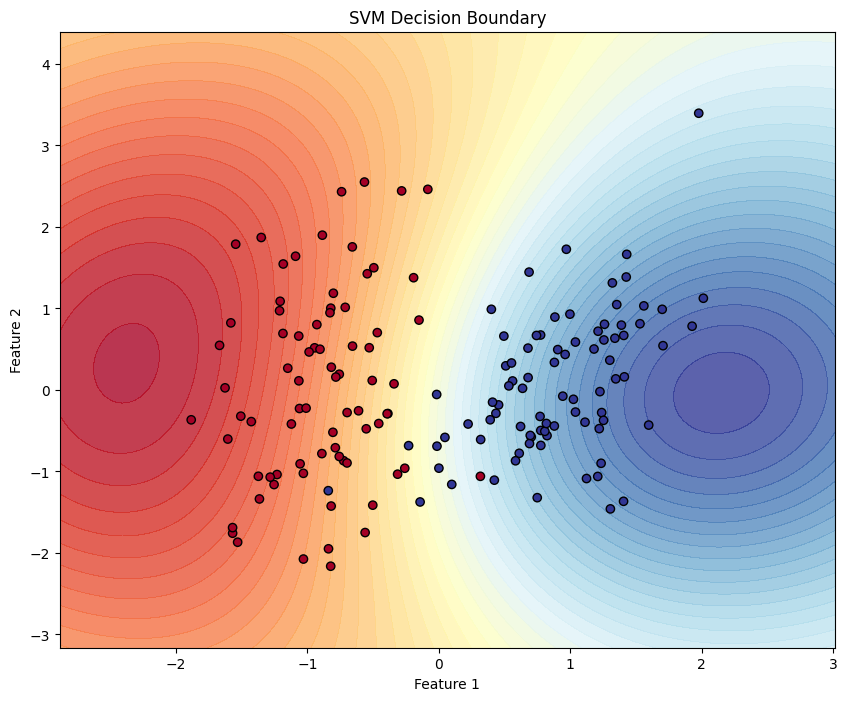

Training SVM with rbf_kernel, param=0.1, C=1


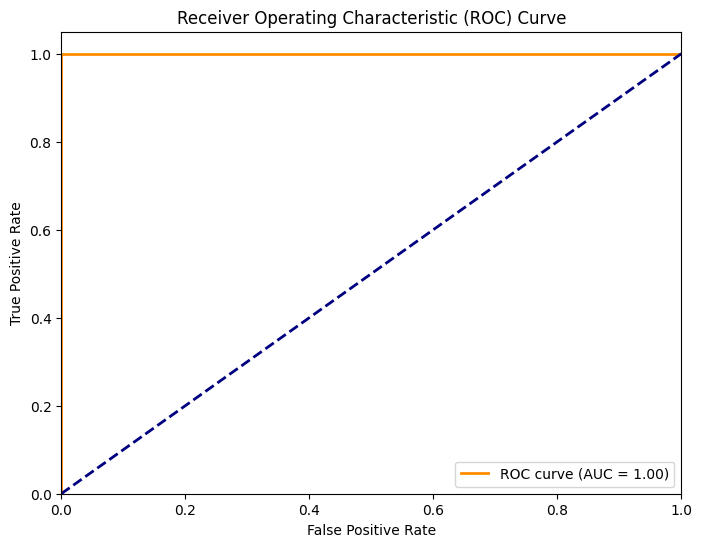

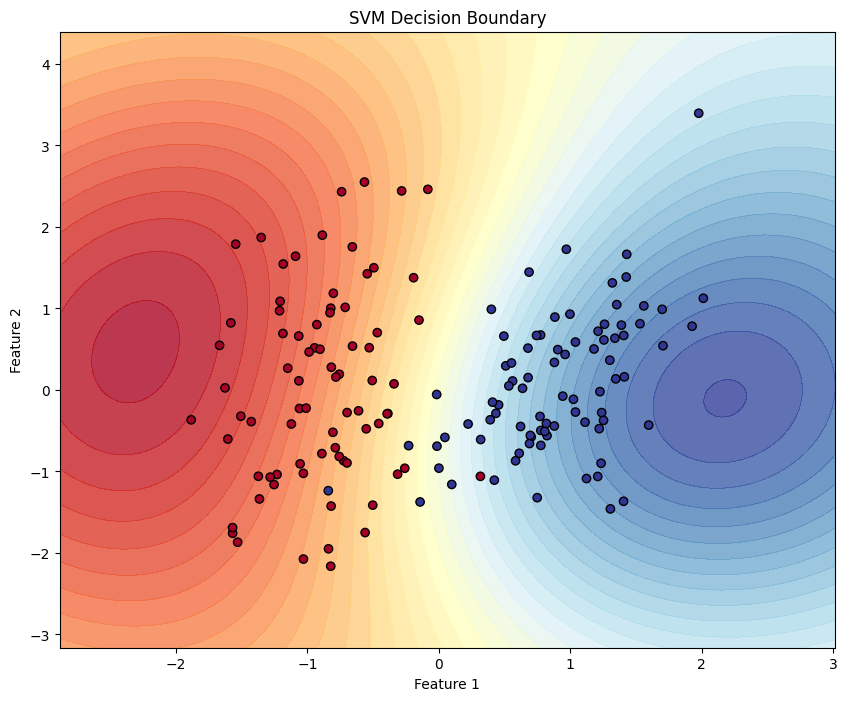

Training SVM with rbf_kernel, param=0.1, C=5


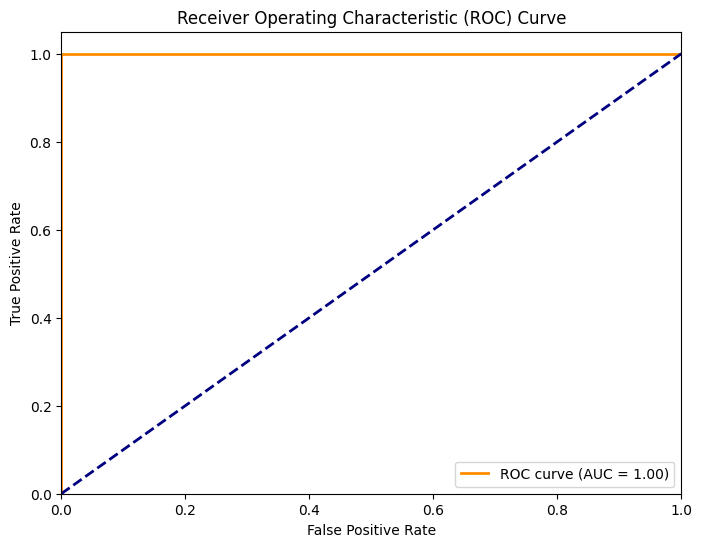

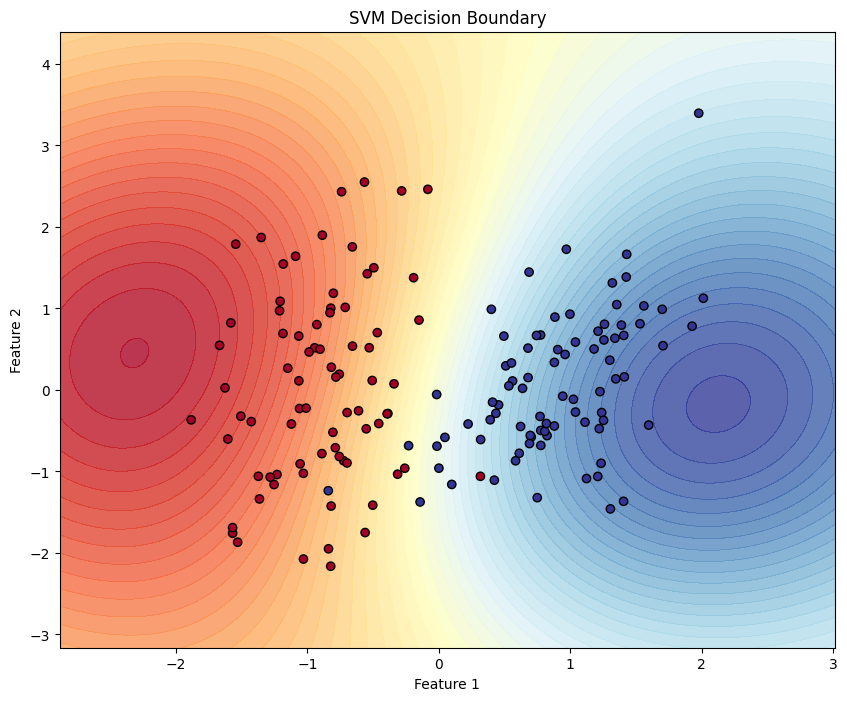

Training SVM with rbf_kernel, param=0.1, C=10


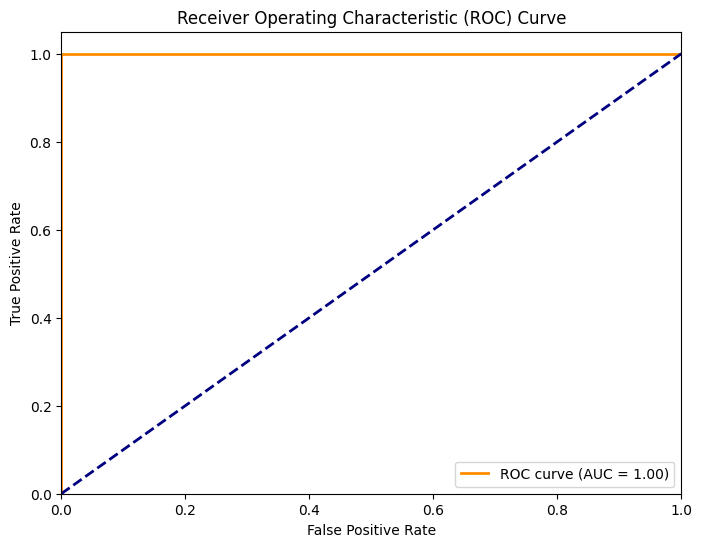

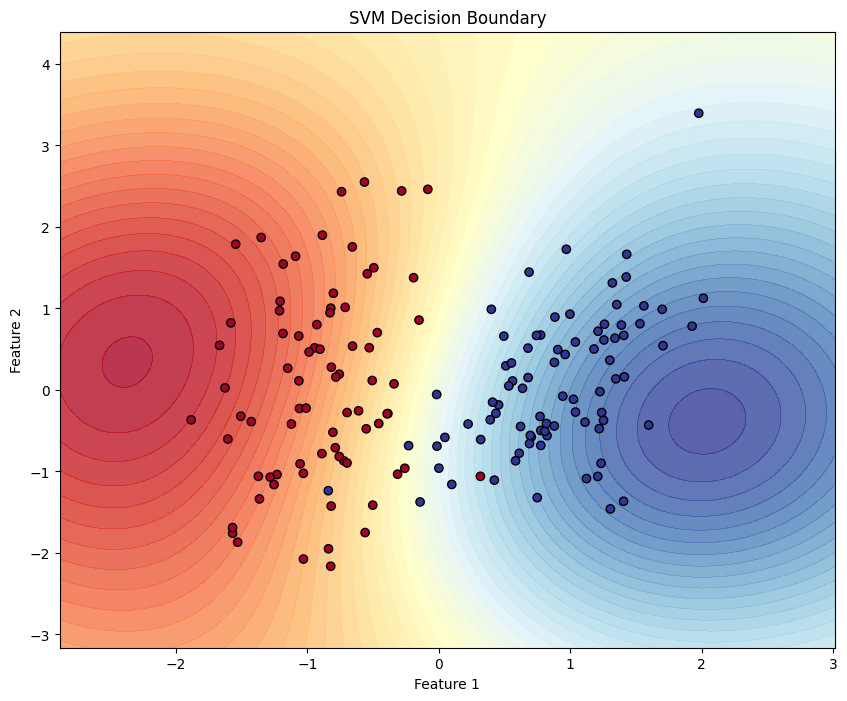

Training SVM with rbf_kernel, param=0.5, C=0.1


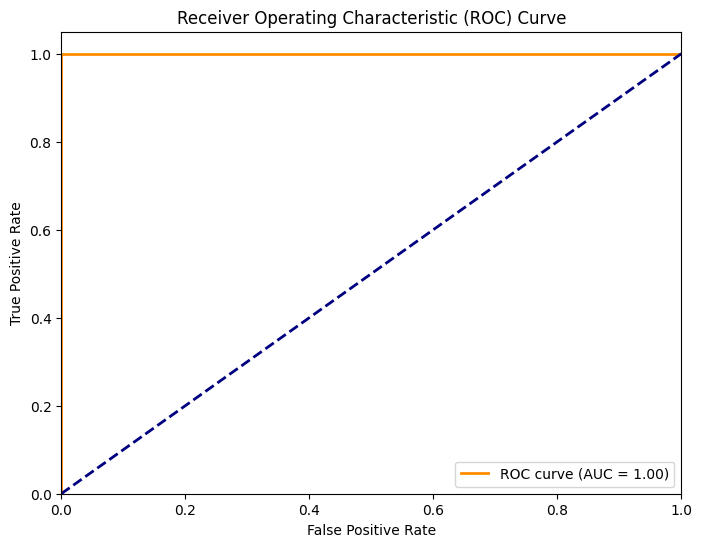

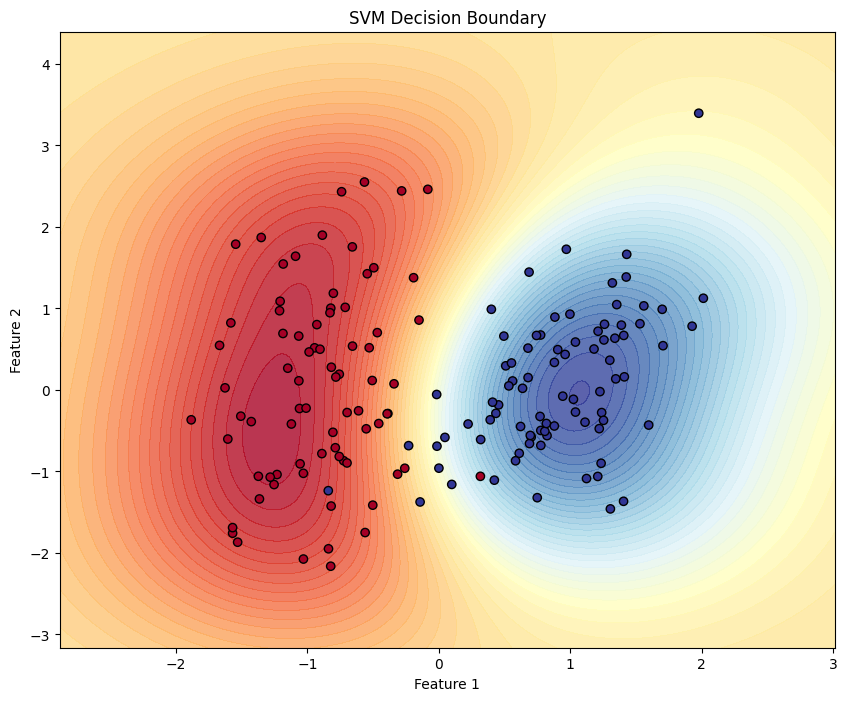

Training SVM with rbf_kernel, param=0.5, C=0.5


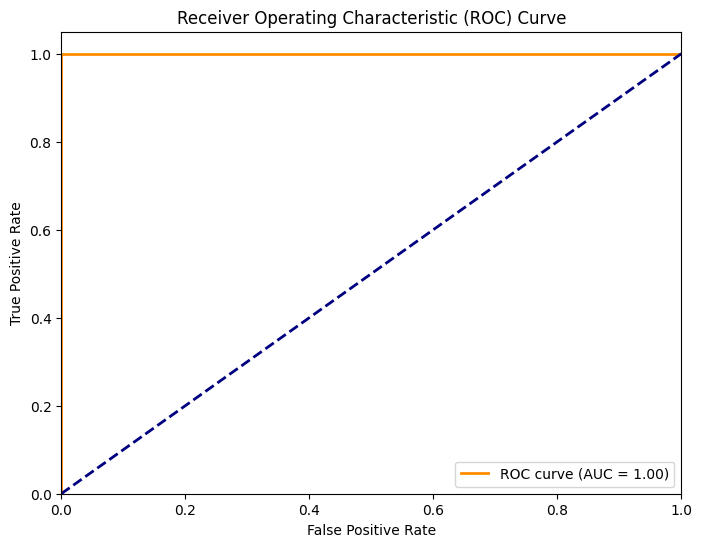

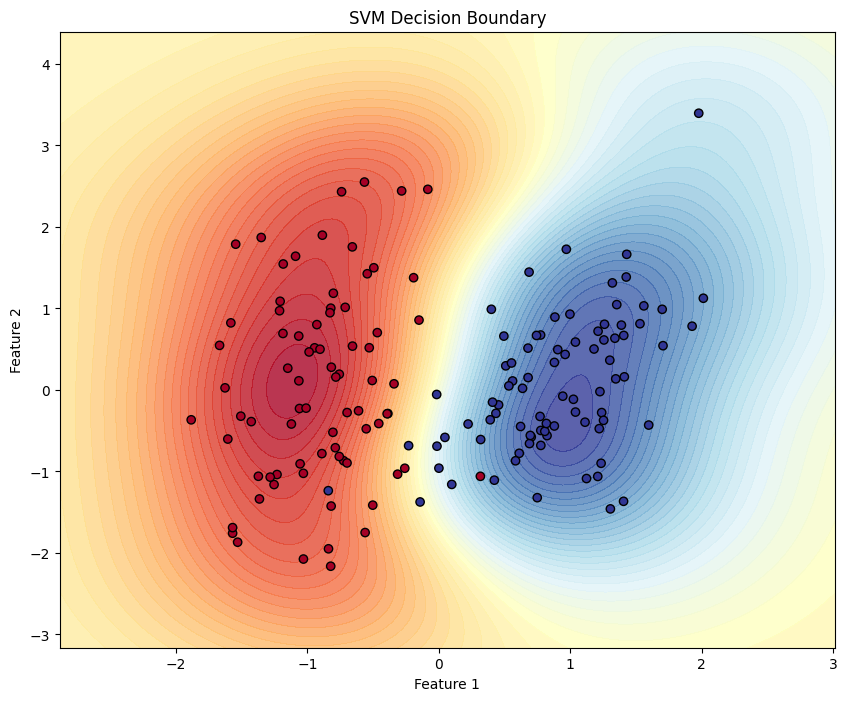

Training SVM with rbf_kernel, param=0.5, C=1


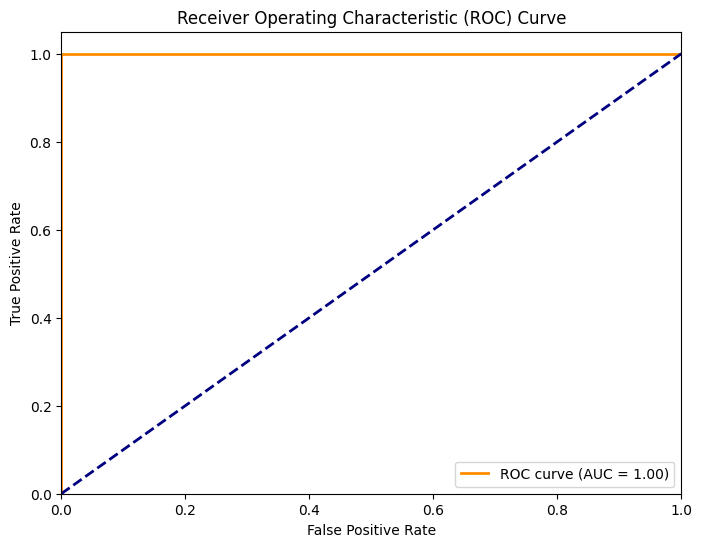

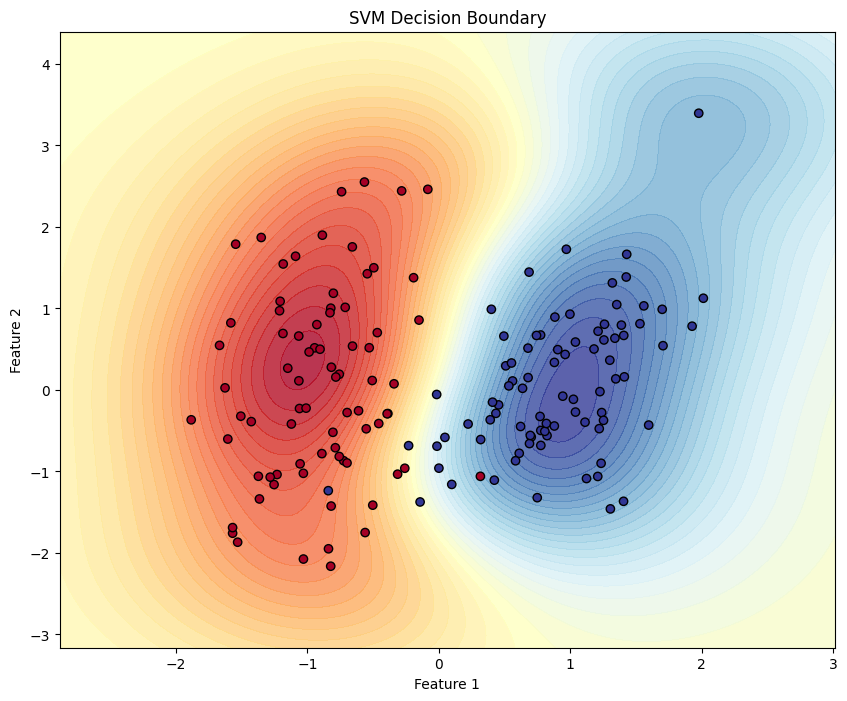

Training SVM with rbf_kernel, param=0.5, C=5


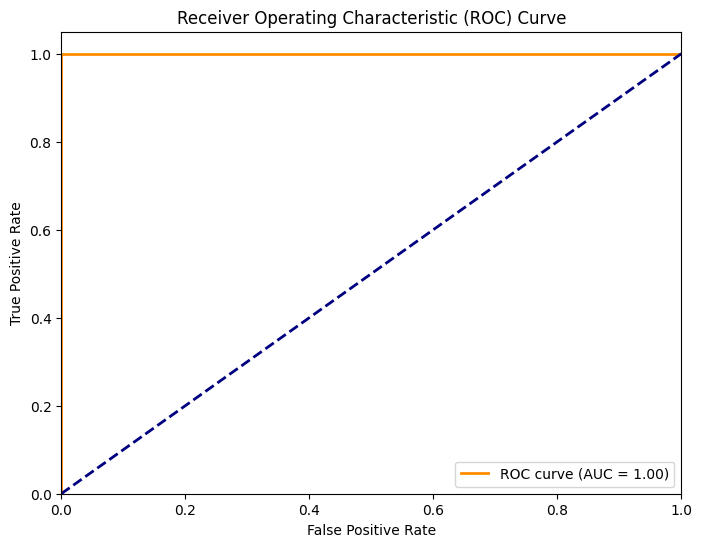

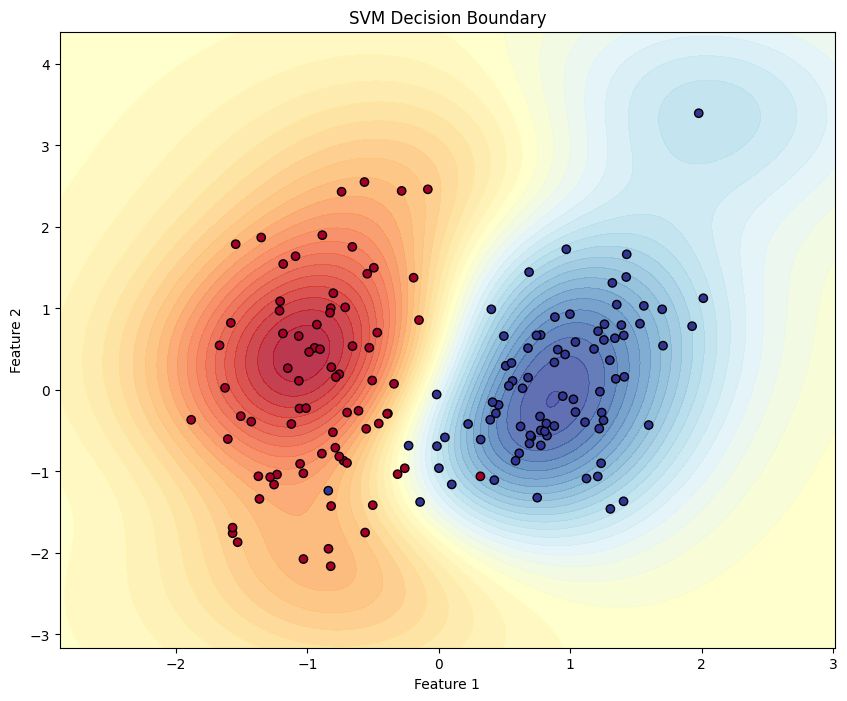

Training SVM with rbf_kernel, param=0.5, C=10


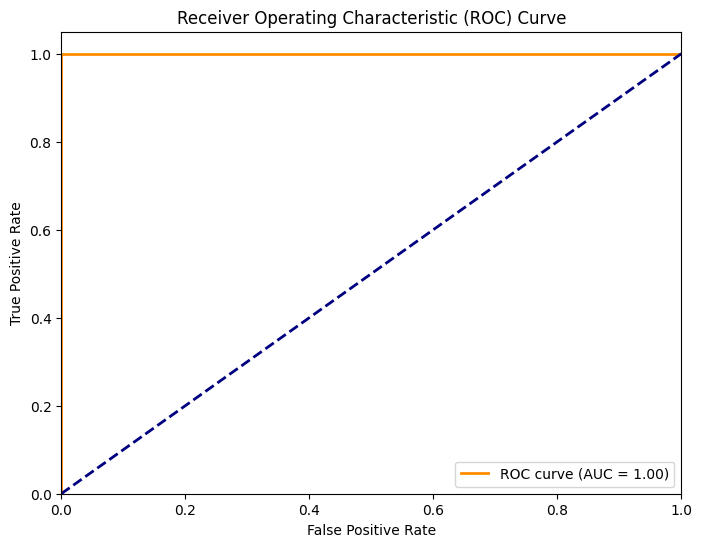

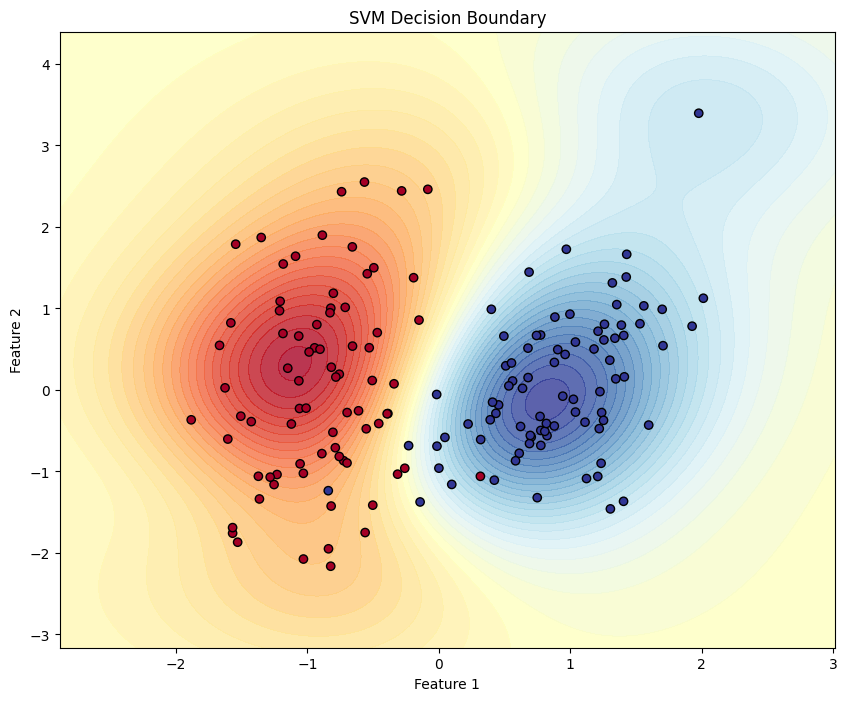

Training SVM with rbf_kernel, param=1, C=0.1


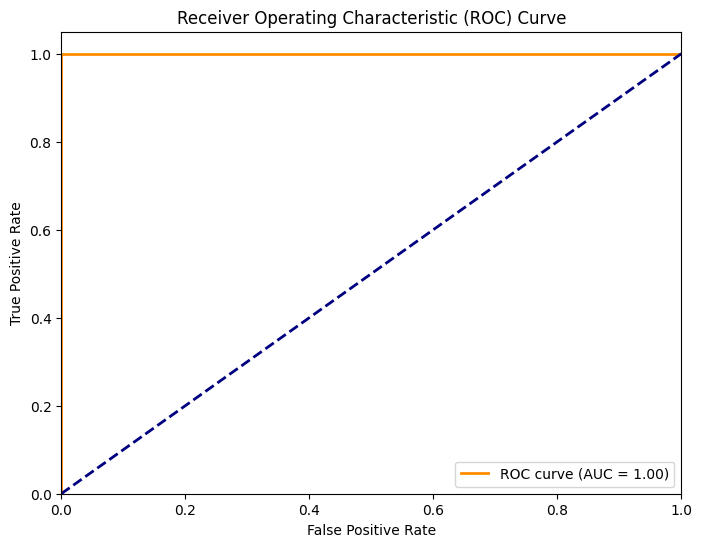

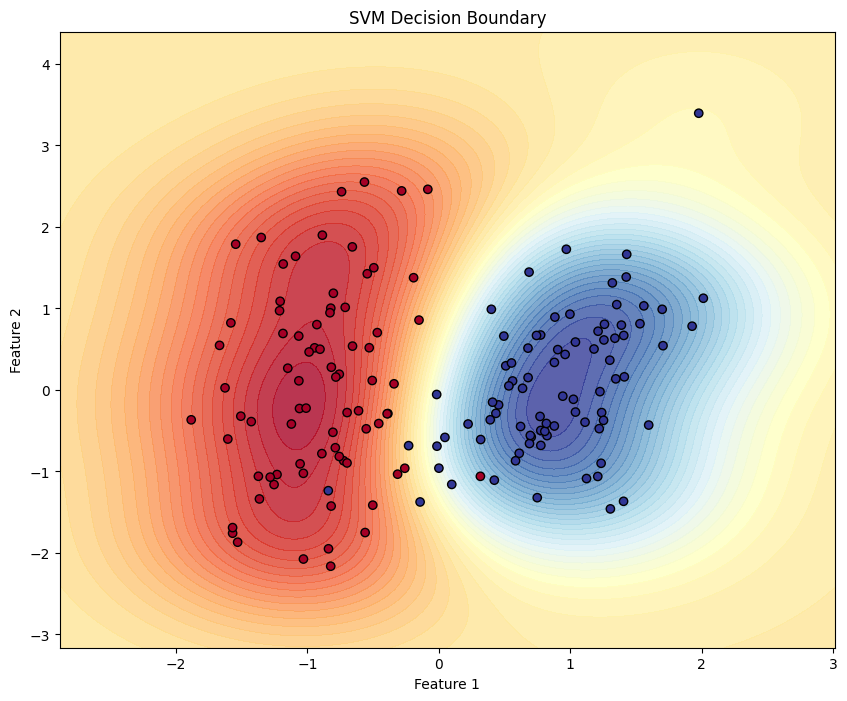

Training SVM with rbf_kernel, param=1, C=0.5


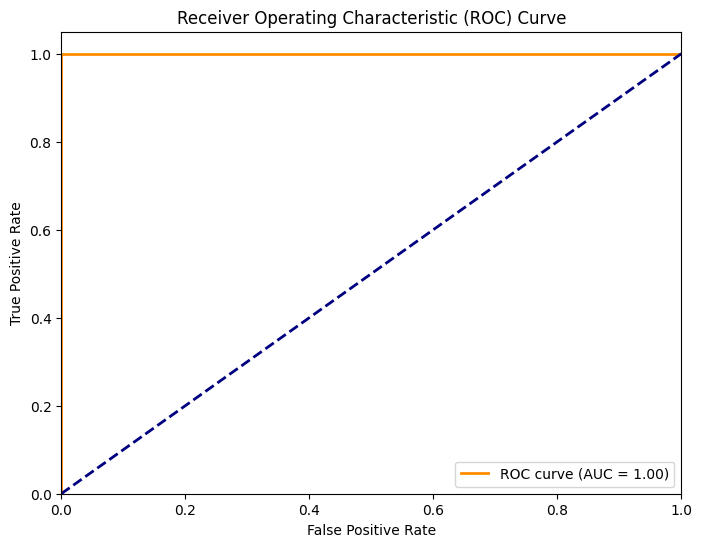

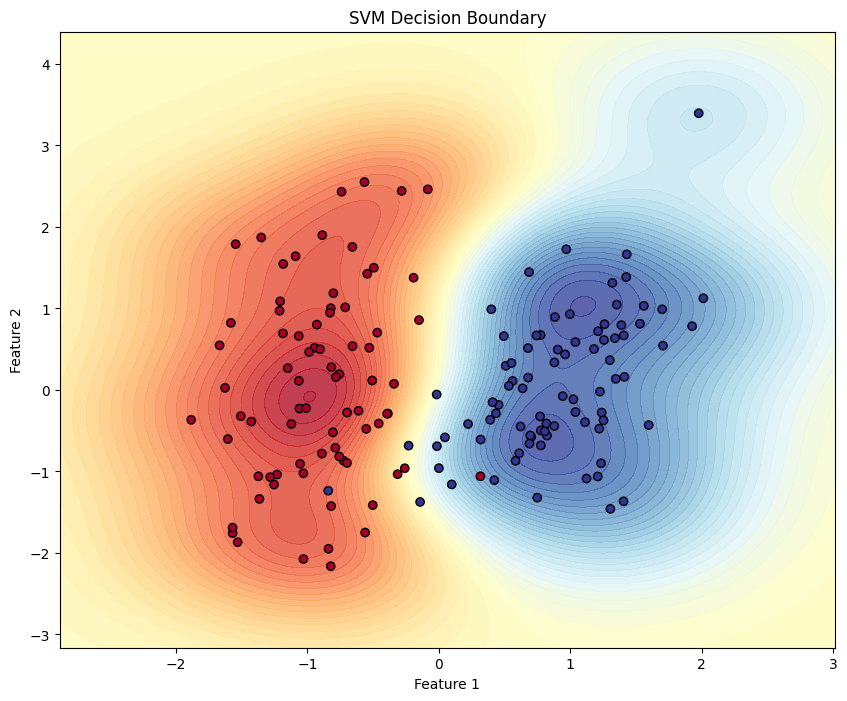

Training SVM with rbf_kernel, param=1, C=1


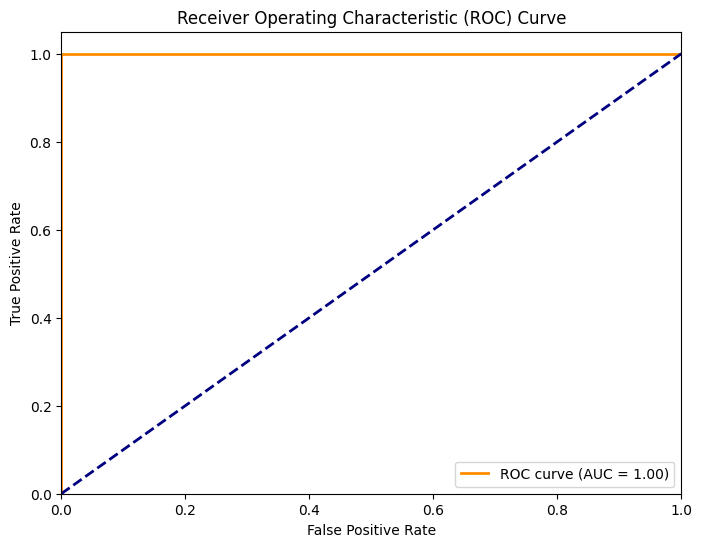

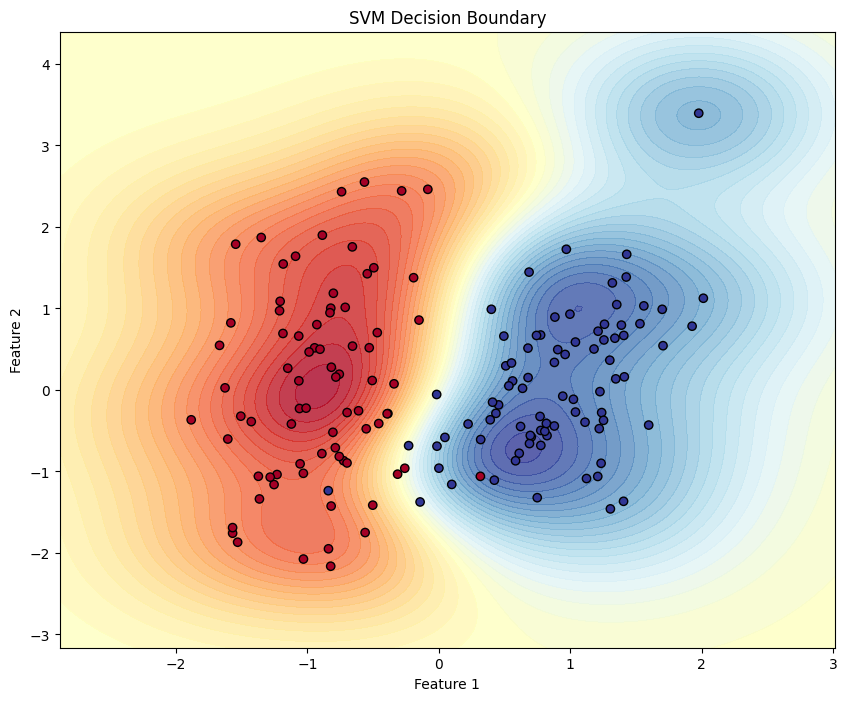

Training SVM with rbf_kernel, param=1, C=5


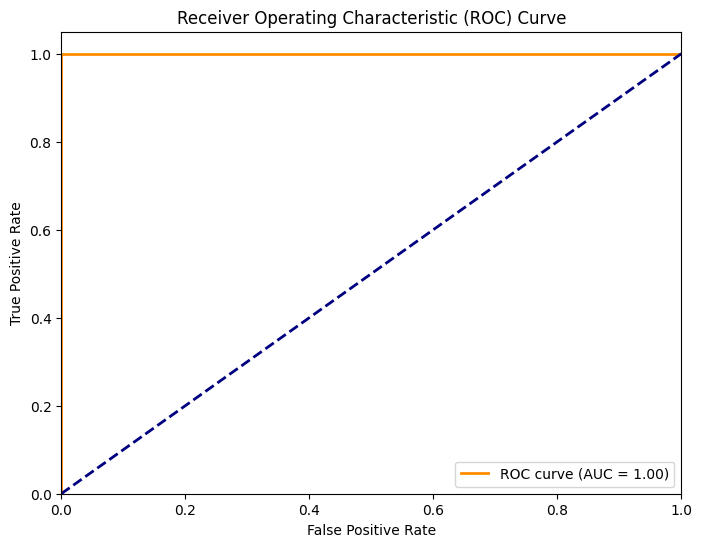

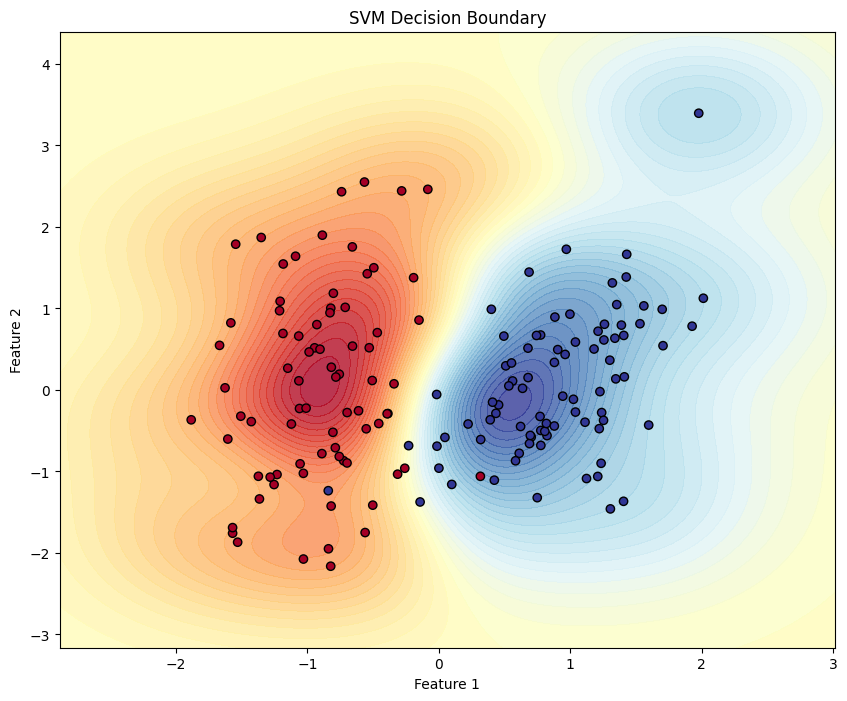

Training SVM with rbf_kernel, param=1, C=10


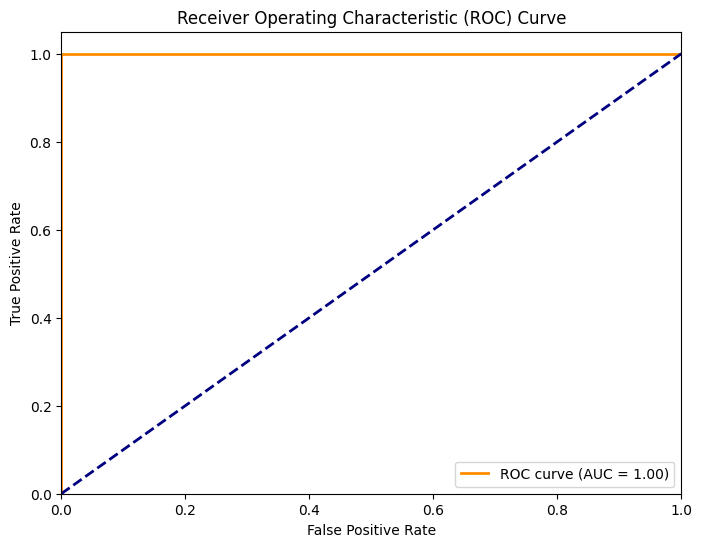

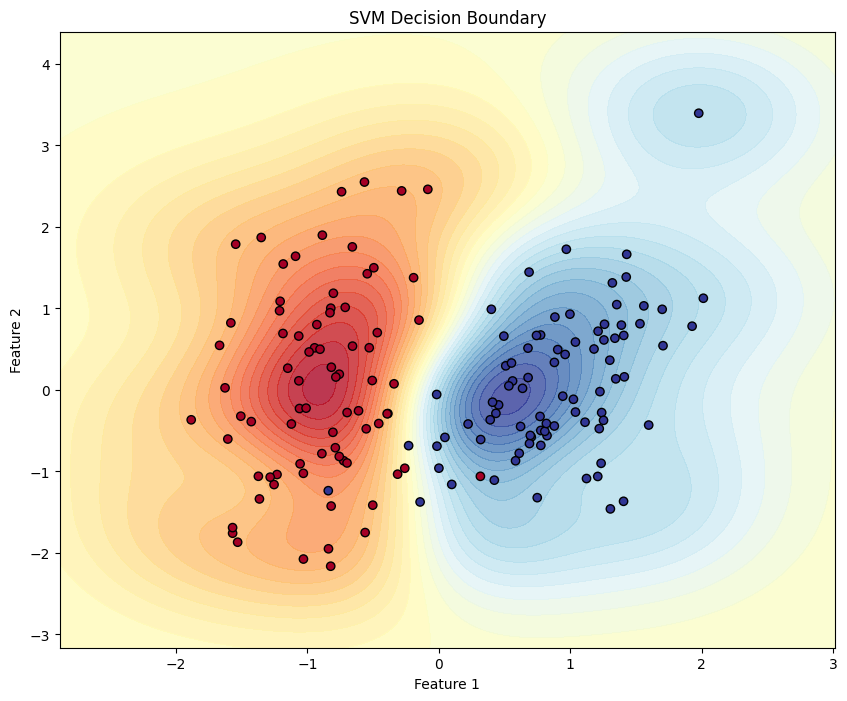

Training SVM with rbf_kernel, param=2, C=0.1


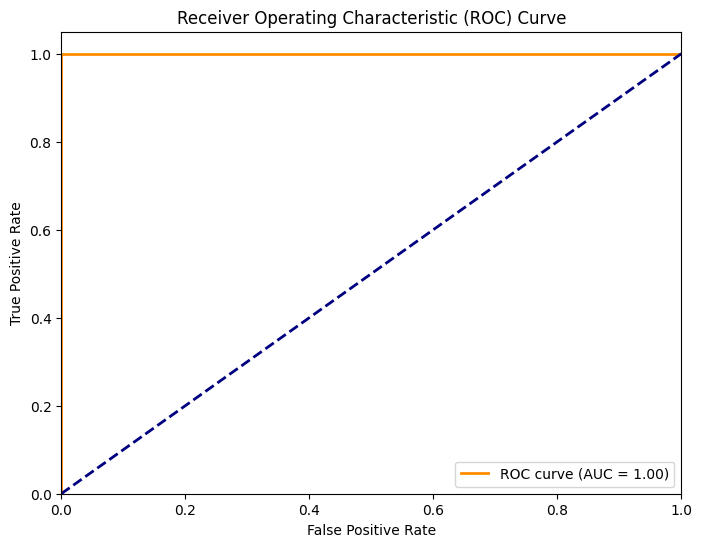

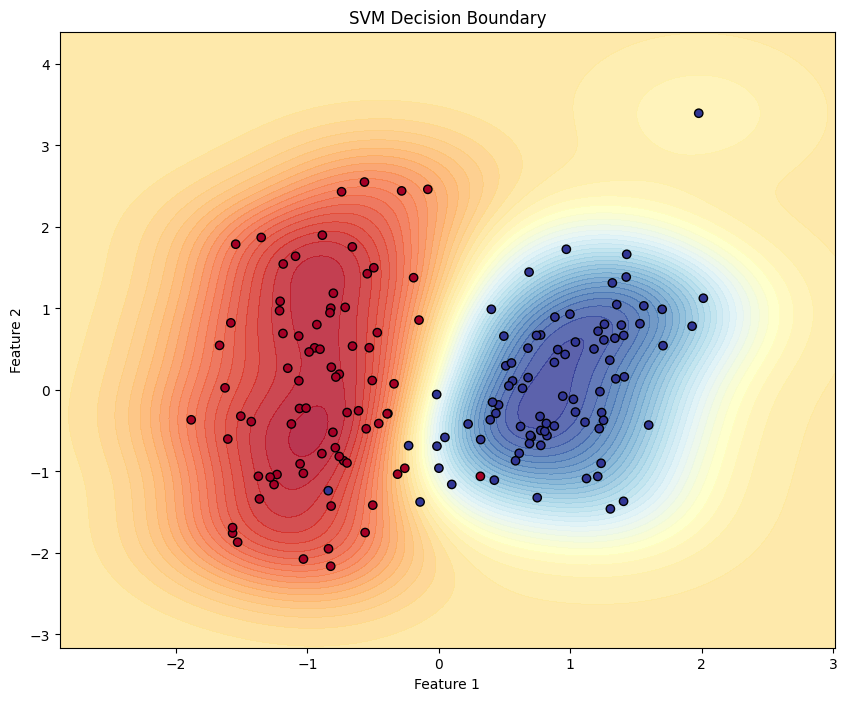

Training SVM with rbf_kernel, param=2, C=0.5


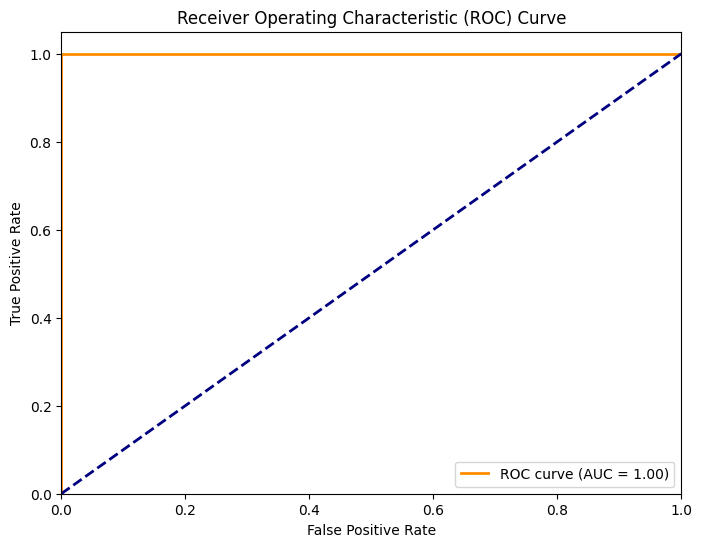

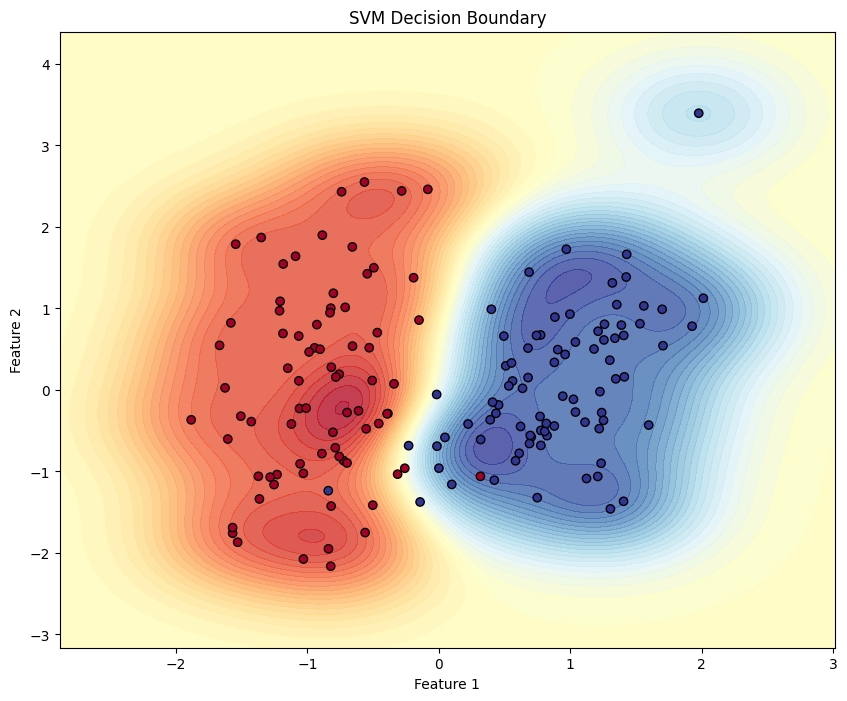

Training SVM with rbf_kernel, param=2, C=1


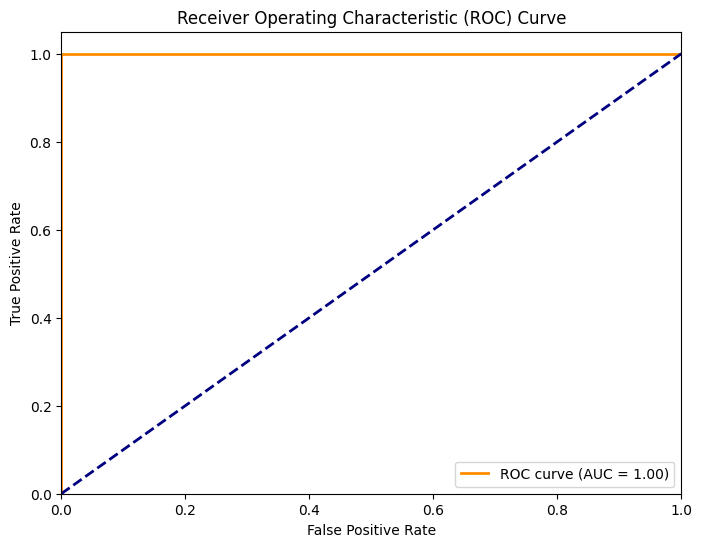

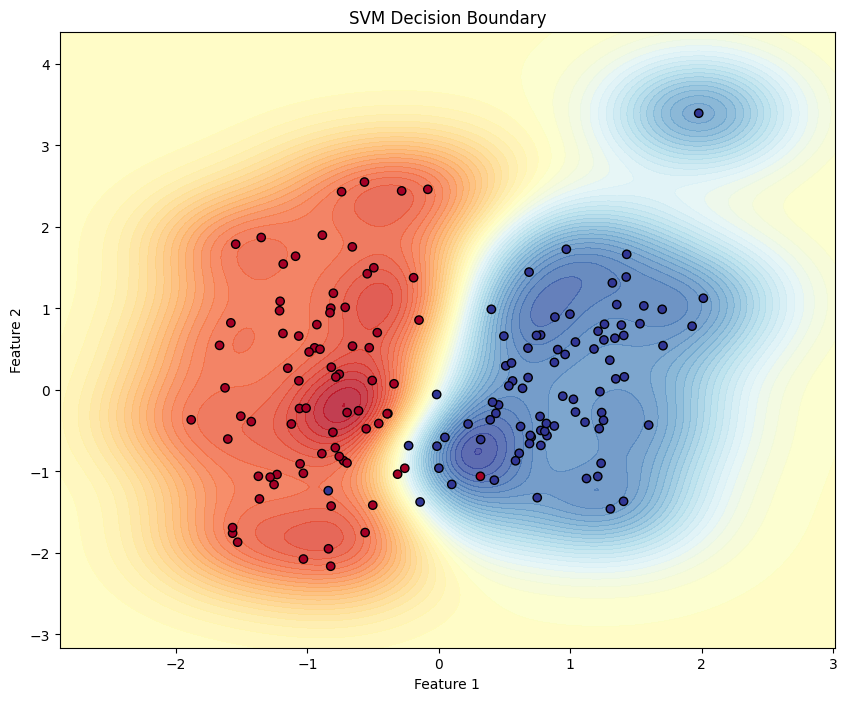

Training SVM with rbf_kernel, param=2, C=5


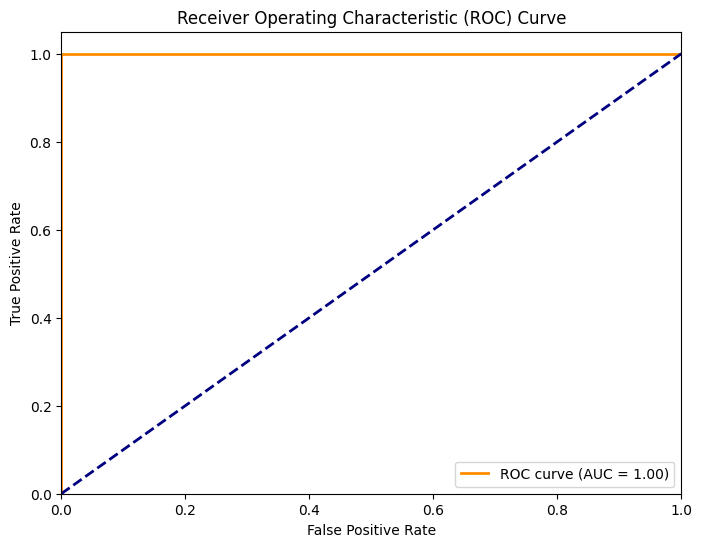

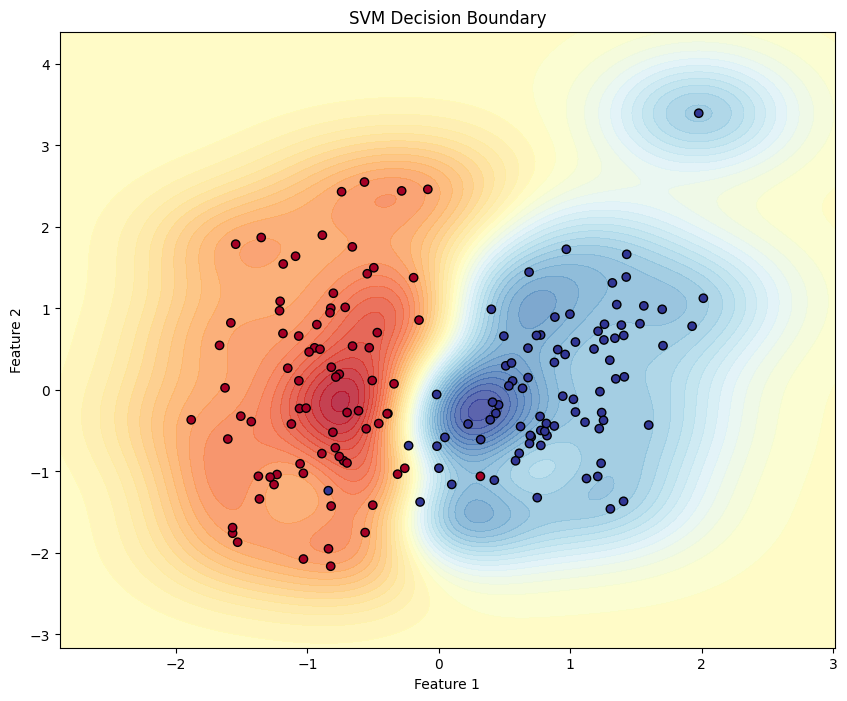

Training SVM with rbf_kernel, param=2, C=10


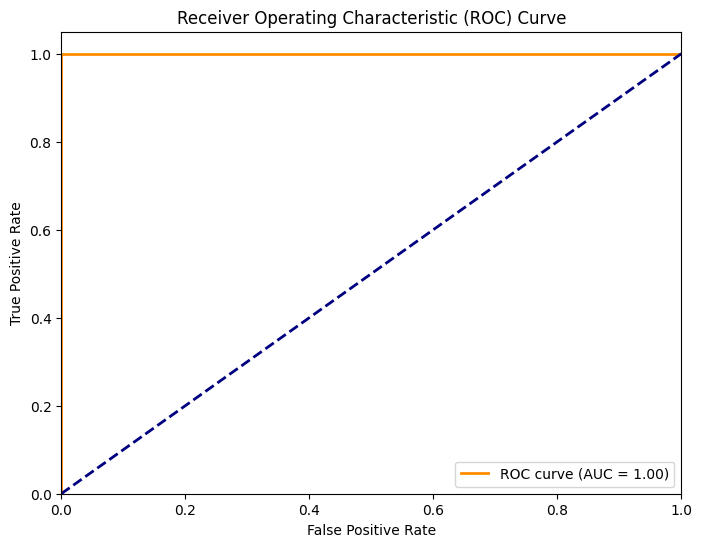

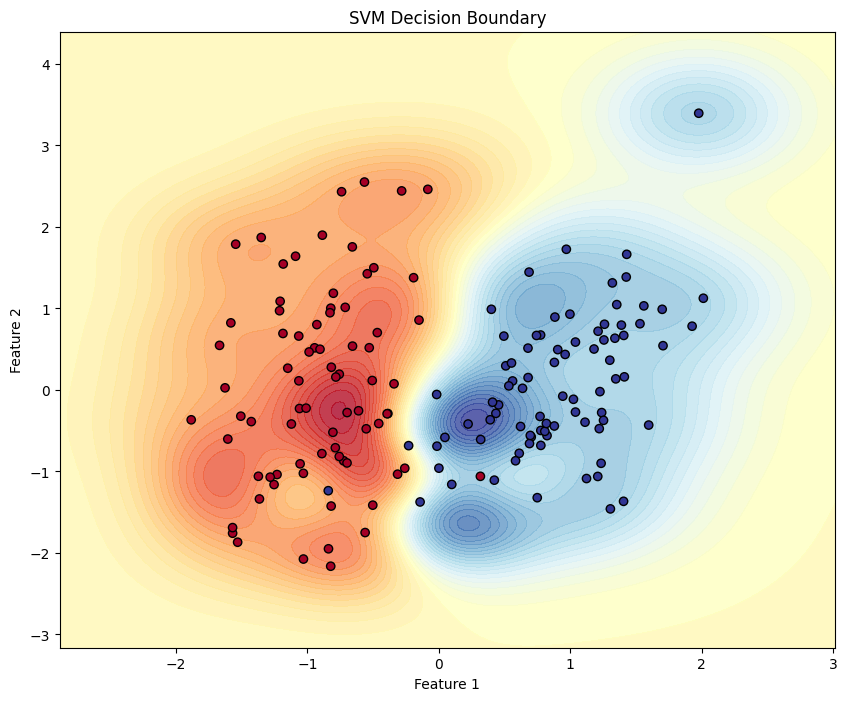

Training SVM with rbf_kernel, param=5, C=0.1


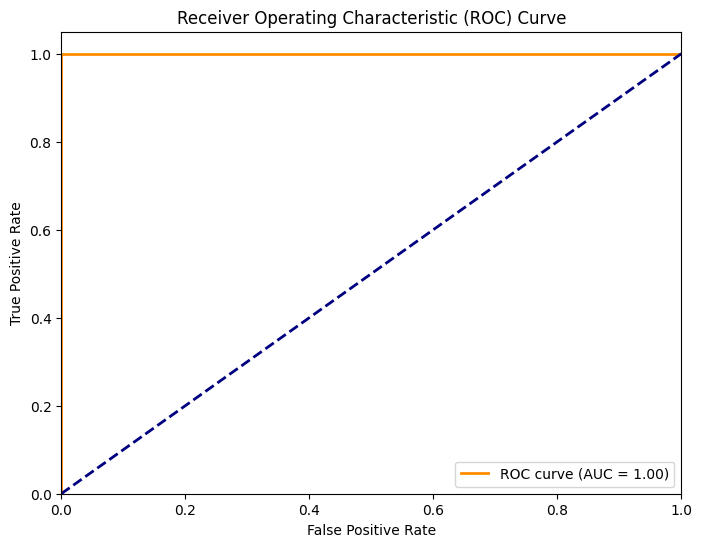

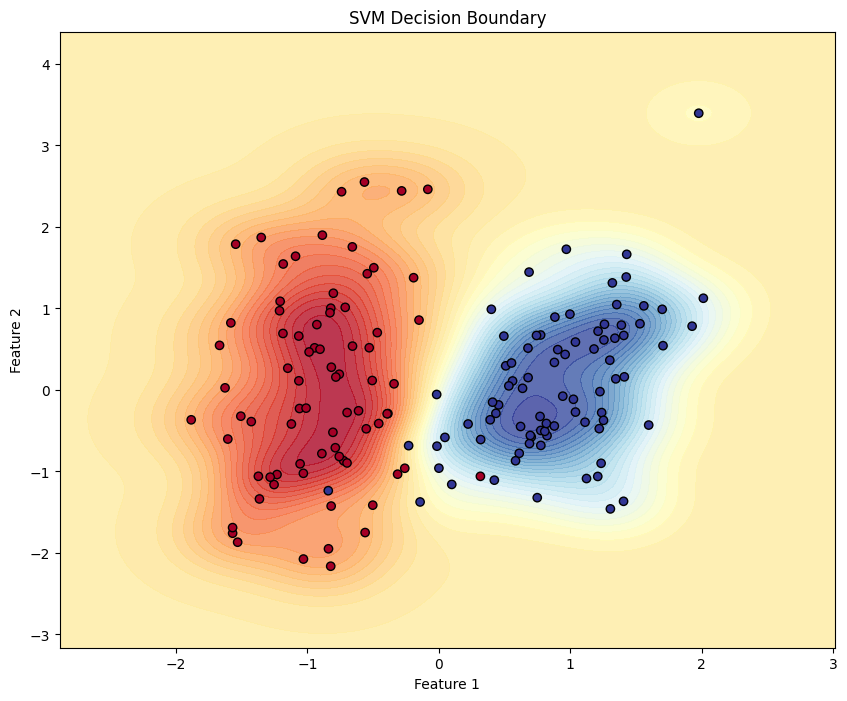

Training SVM with rbf_kernel, param=5, C=0.5


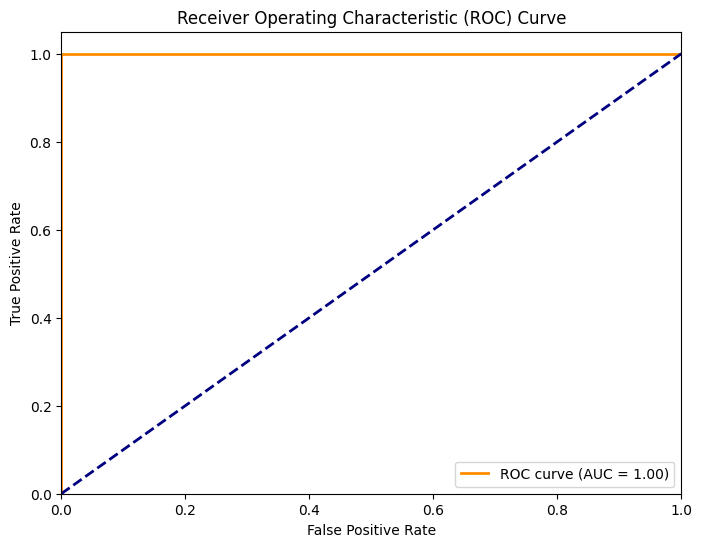

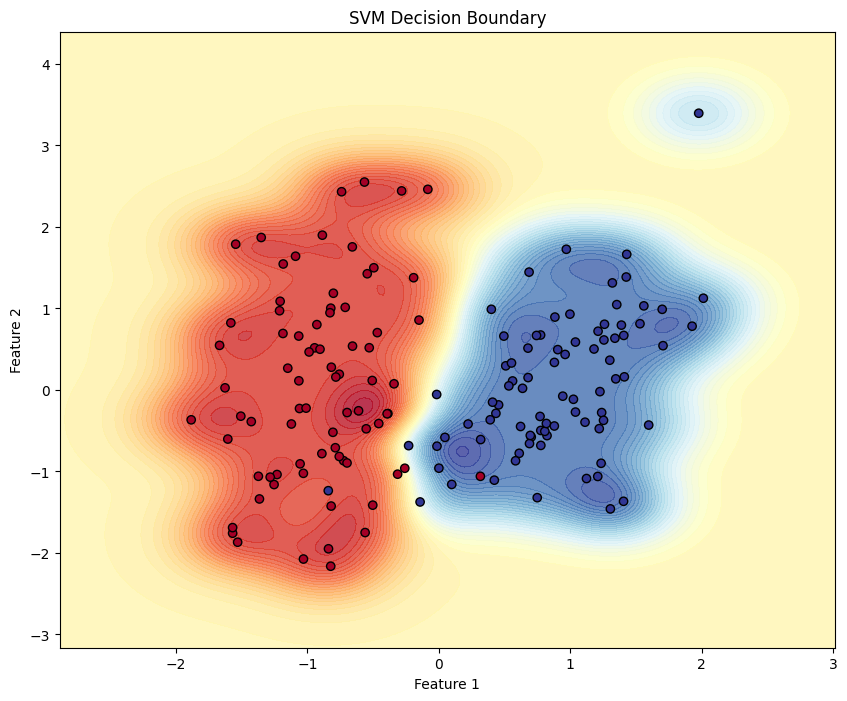

Training SVM with rbf_kernel, param=5, C=1


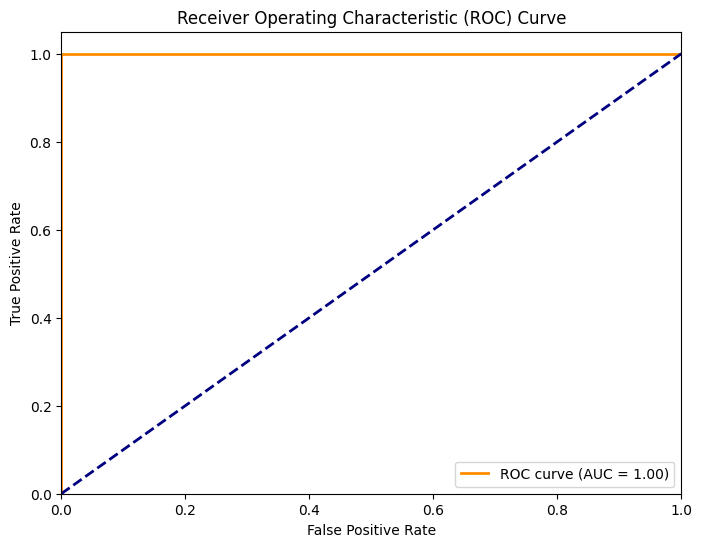

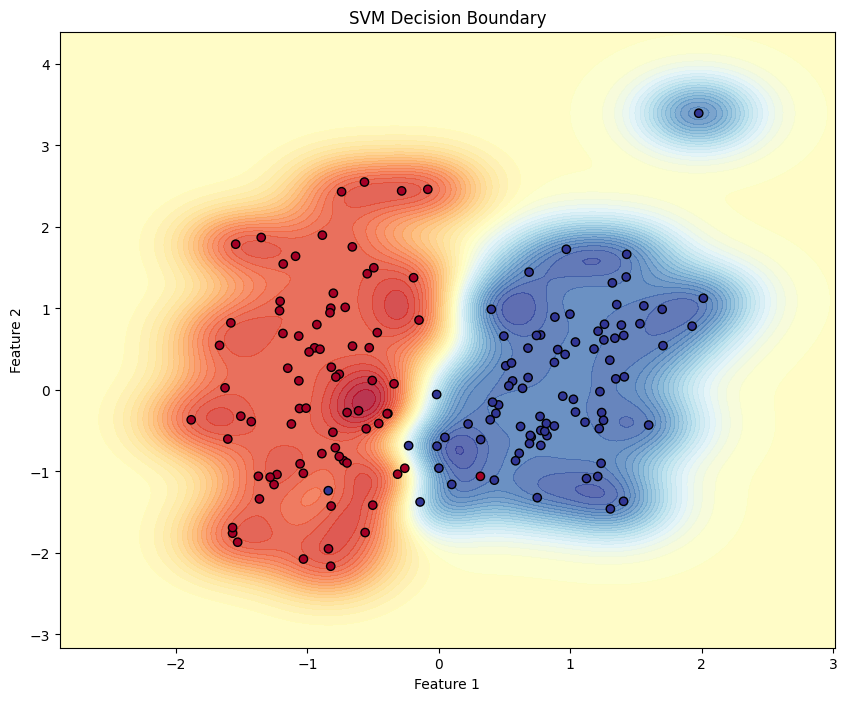

Training SVM with rbf_kernel, param=5, C=5


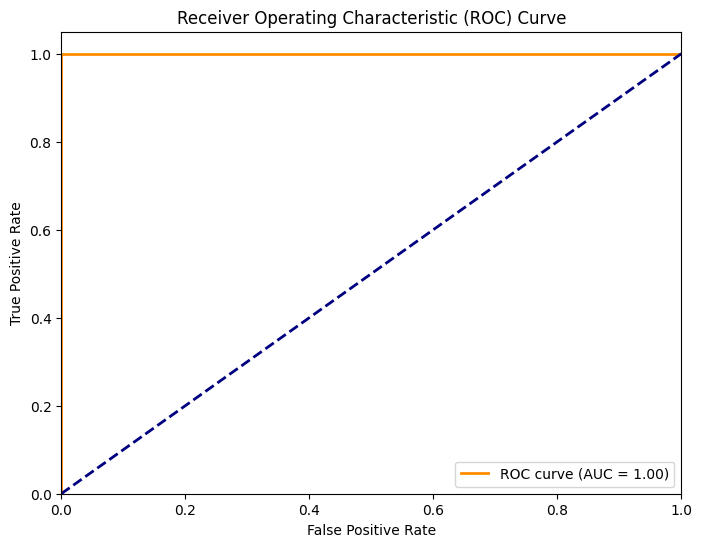

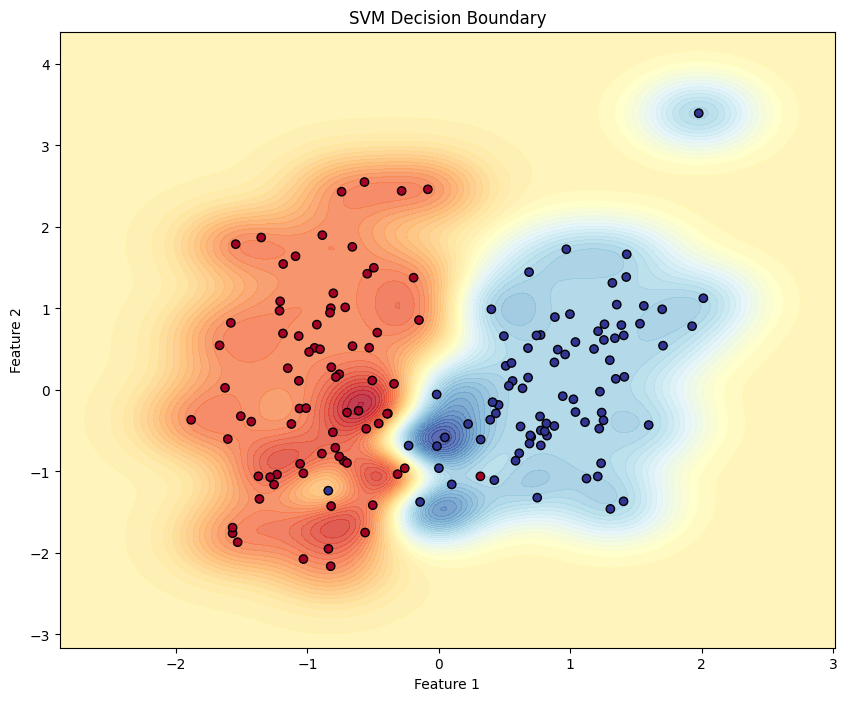

Training SVM with rbf_kernel, param=5, C=10


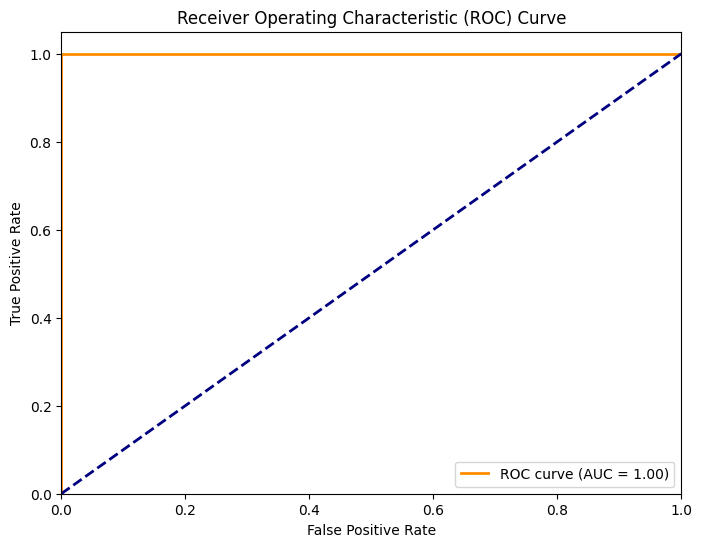

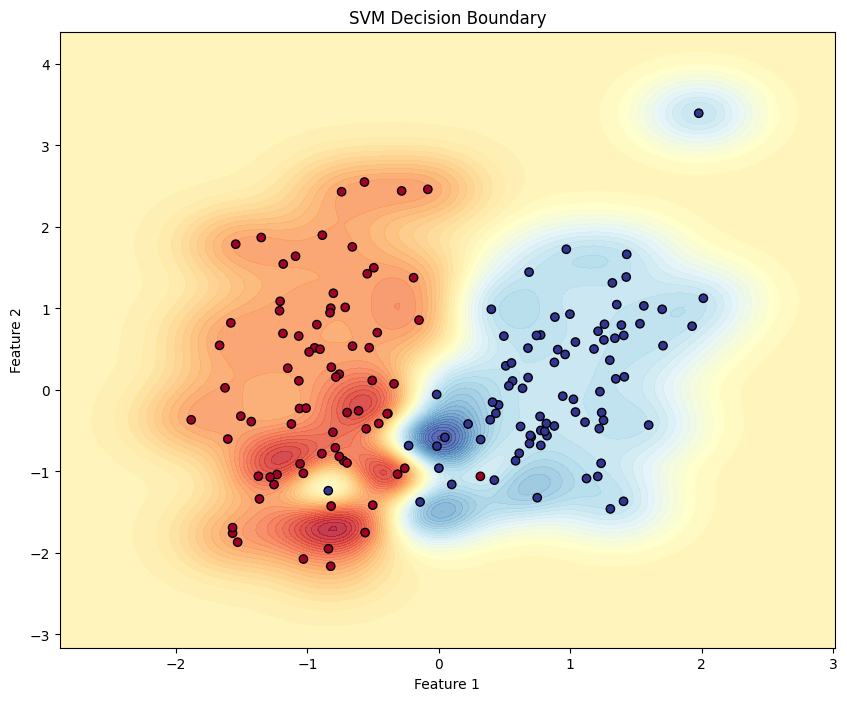

Training SVM with polynomial_kernel, param=2, C=0.1


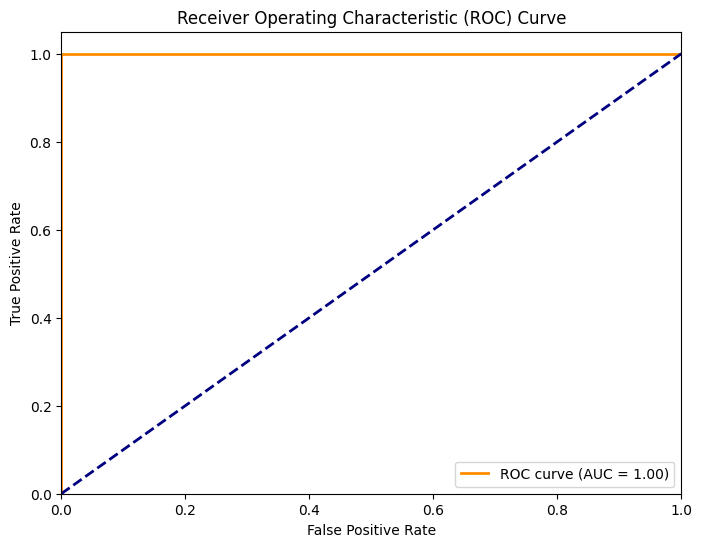

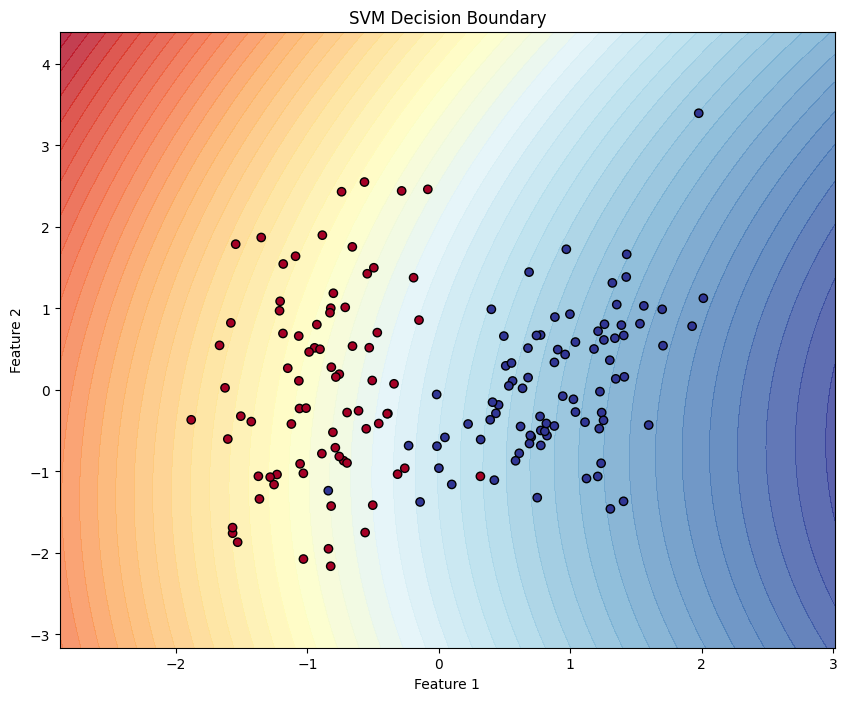

Training SVM with polynomial_kernel, param=2, C=0.5


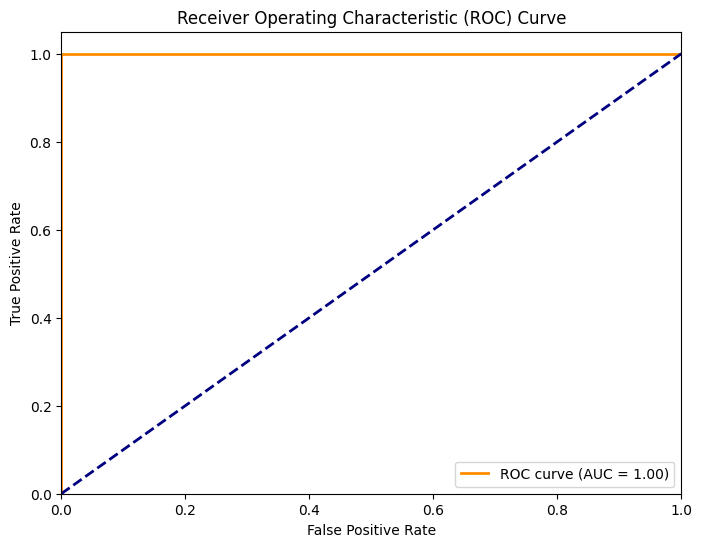

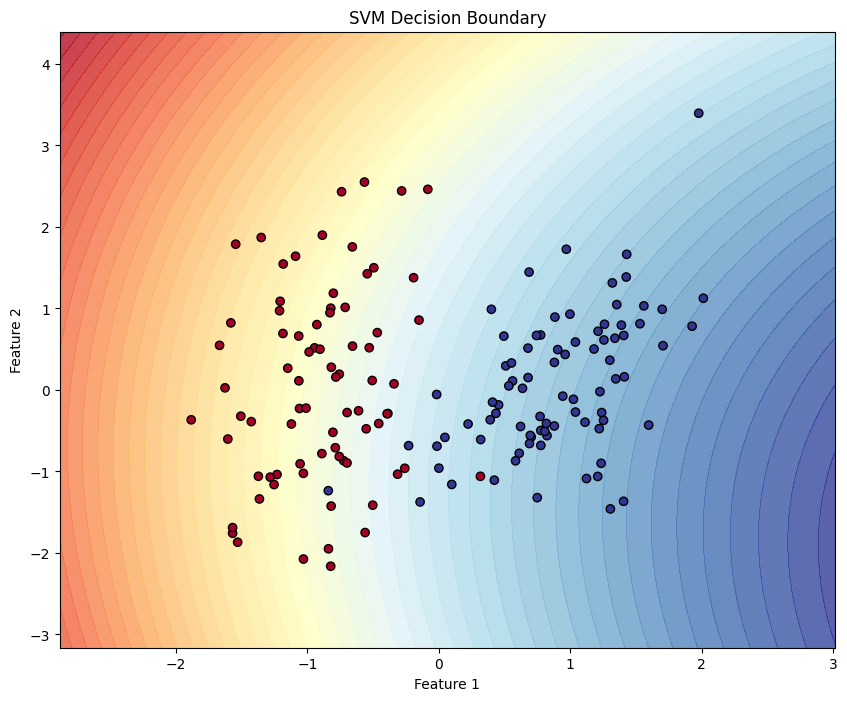

Training SVM with polynomial_kernel, param=2, C=1


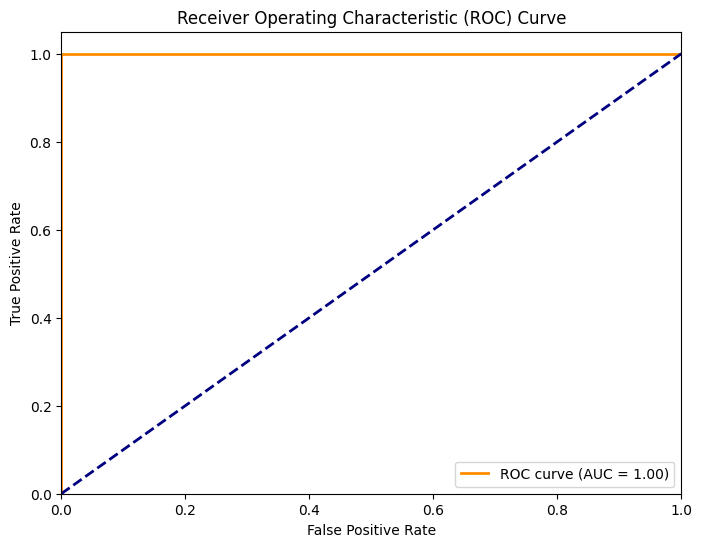

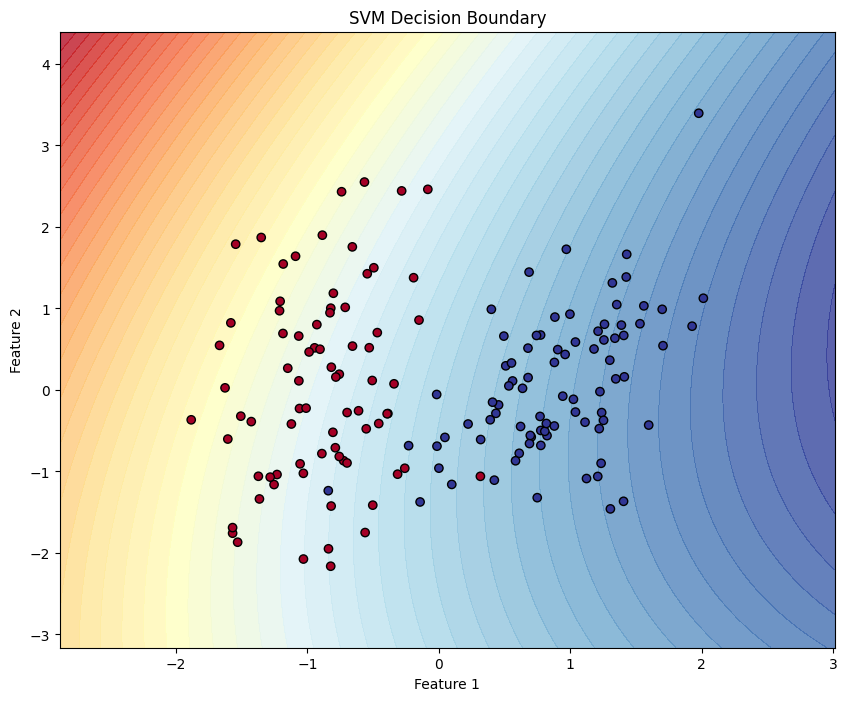

Training SVM with polynomial_kernel, param=2, C=5


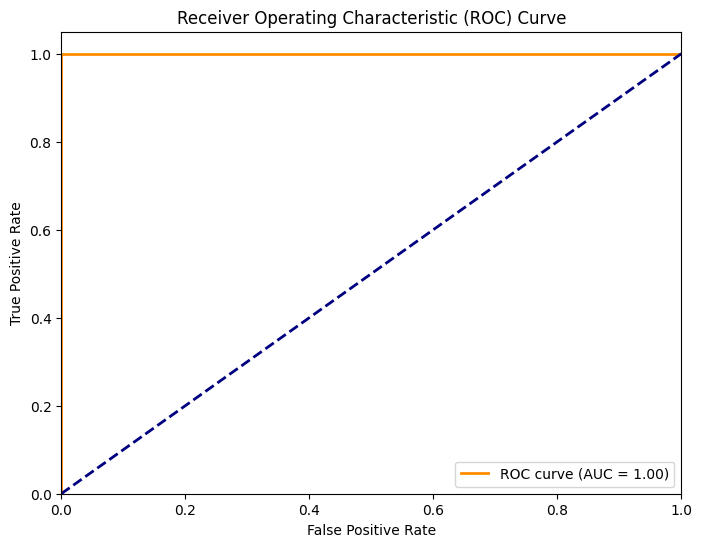

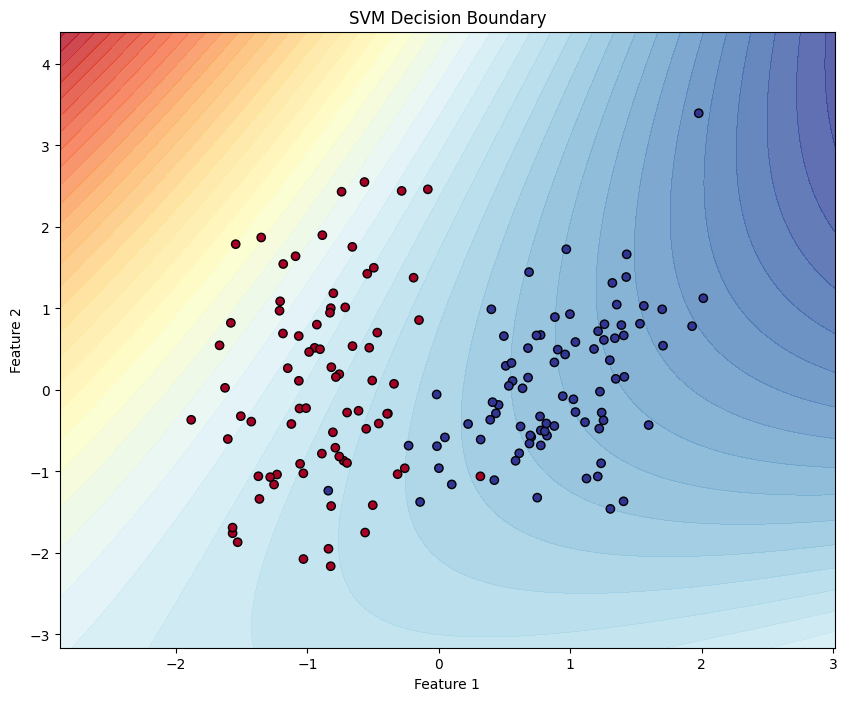

Training SVM with polynomial_kernel, param=2, C=10


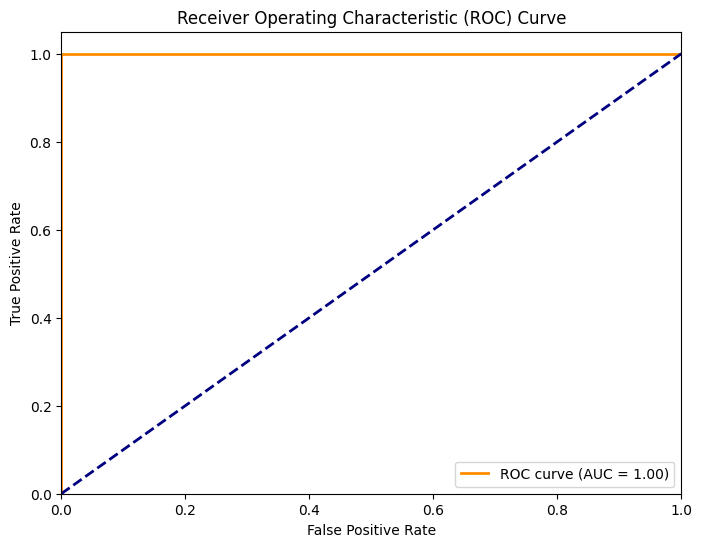

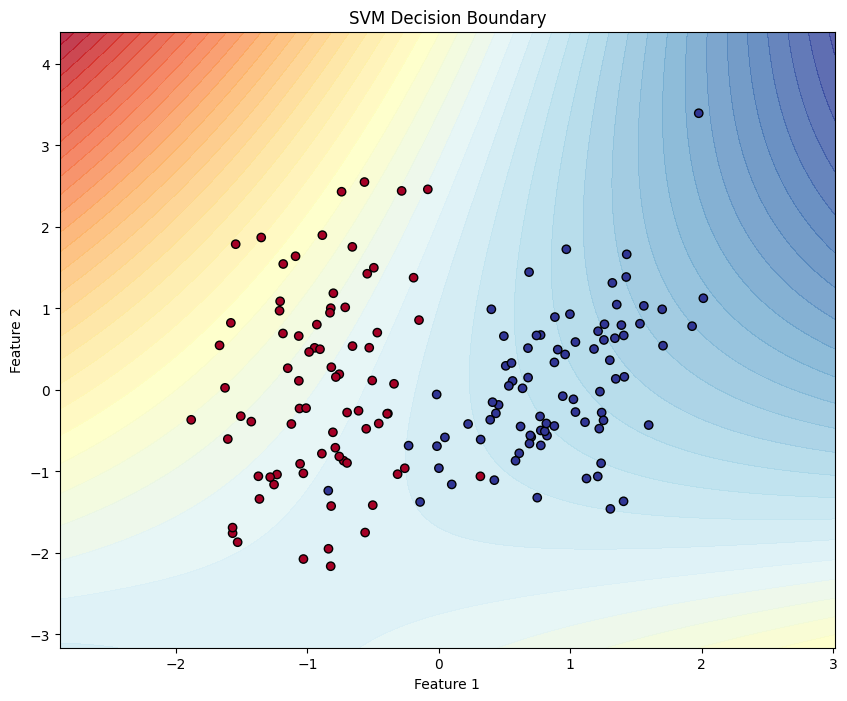

Training SVM with polynomial_kernel, param=3, C=0.1


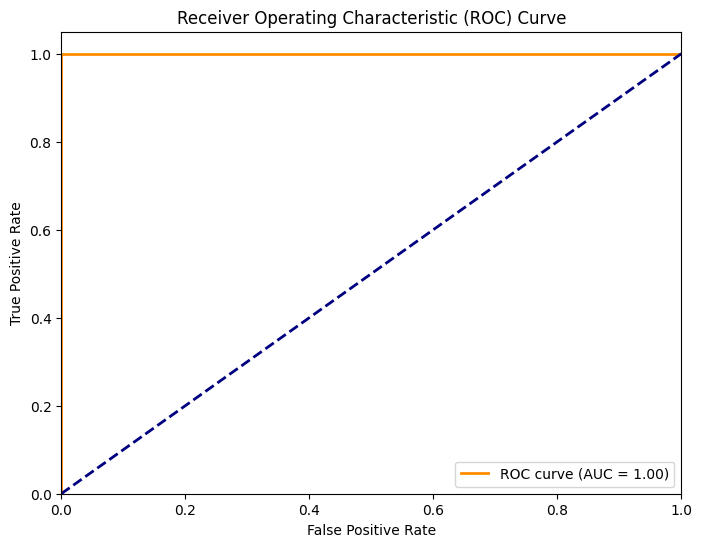

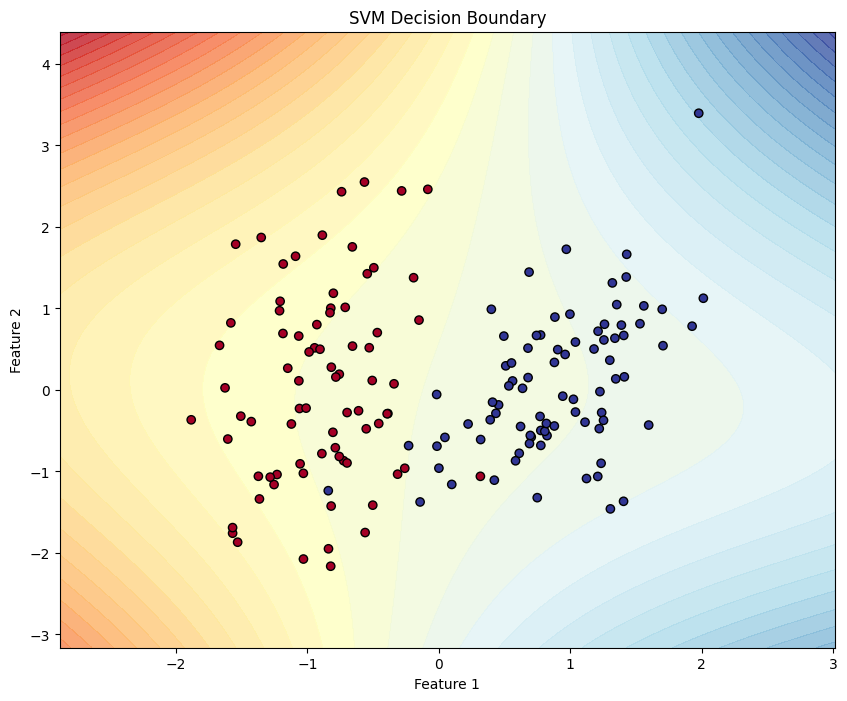

Training SVM with polynomial_kernel, param=3, C=0.5


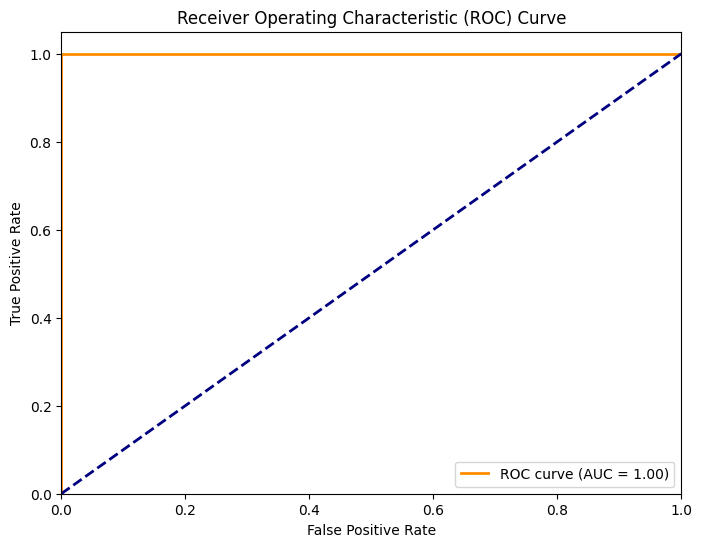

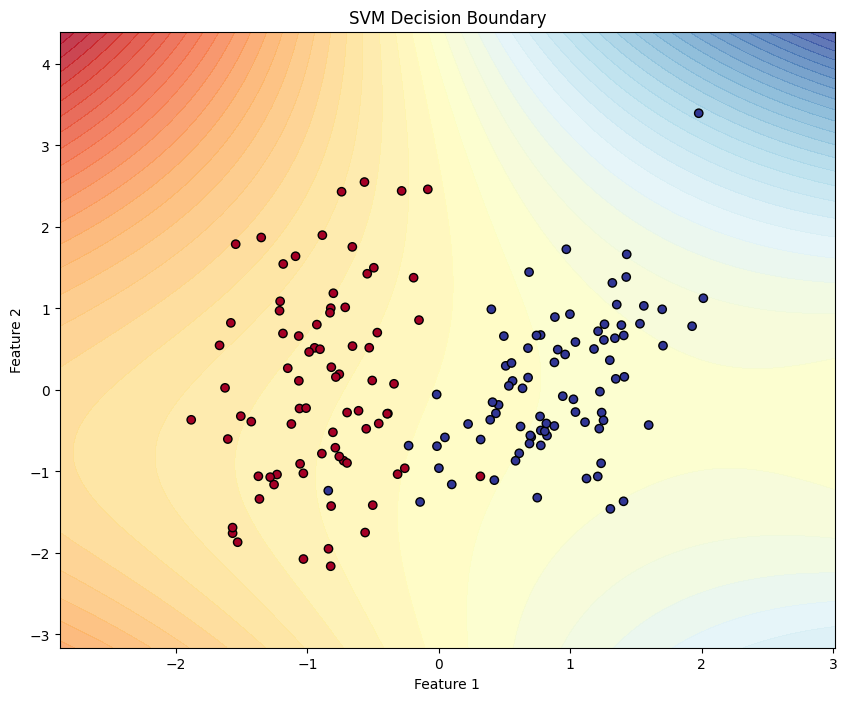

Training SVM with polynomial_kernel, param=3, C=1


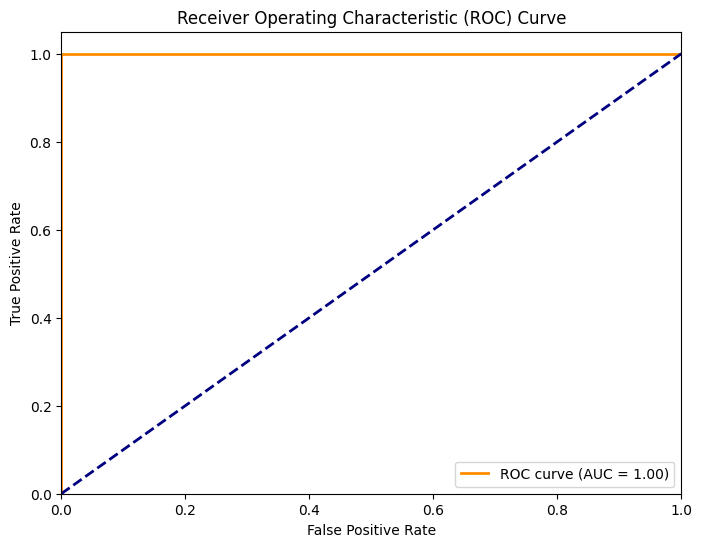

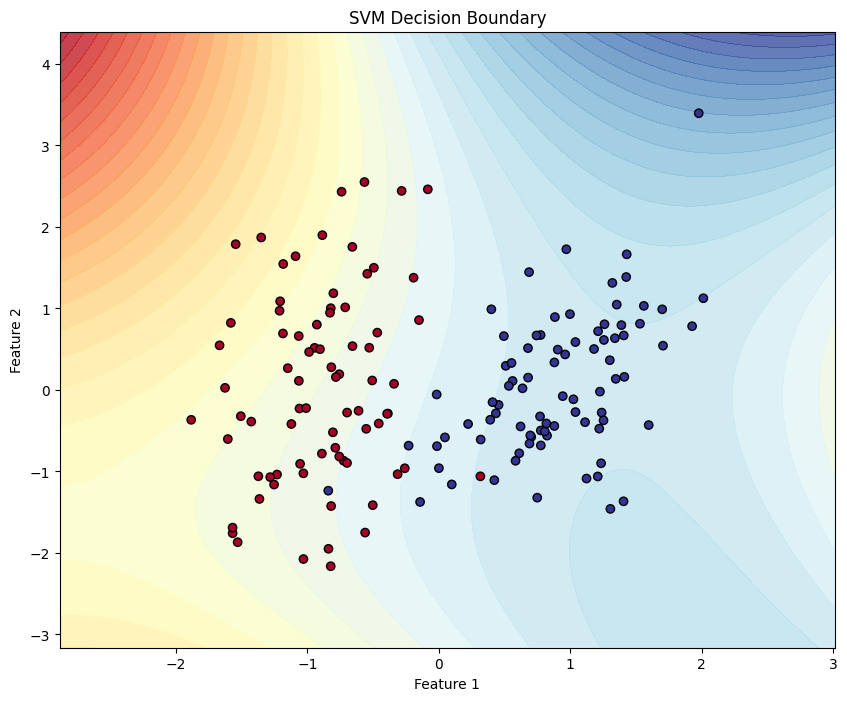

Training SVM with polynomial_kernel, param=3, C=5


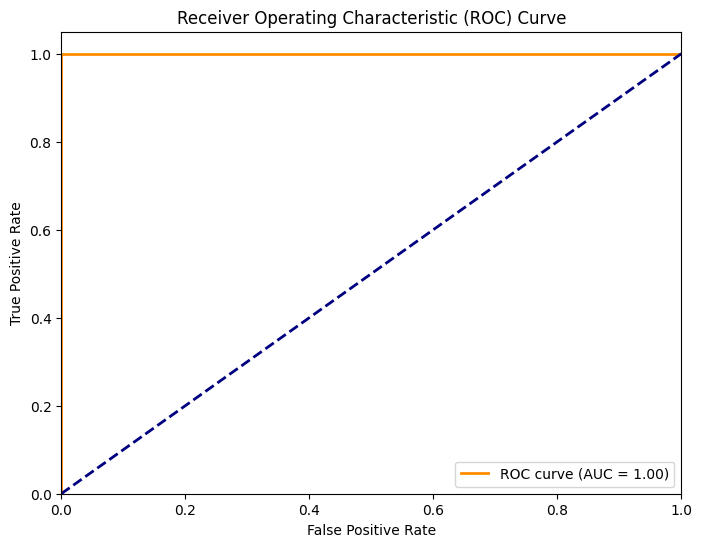

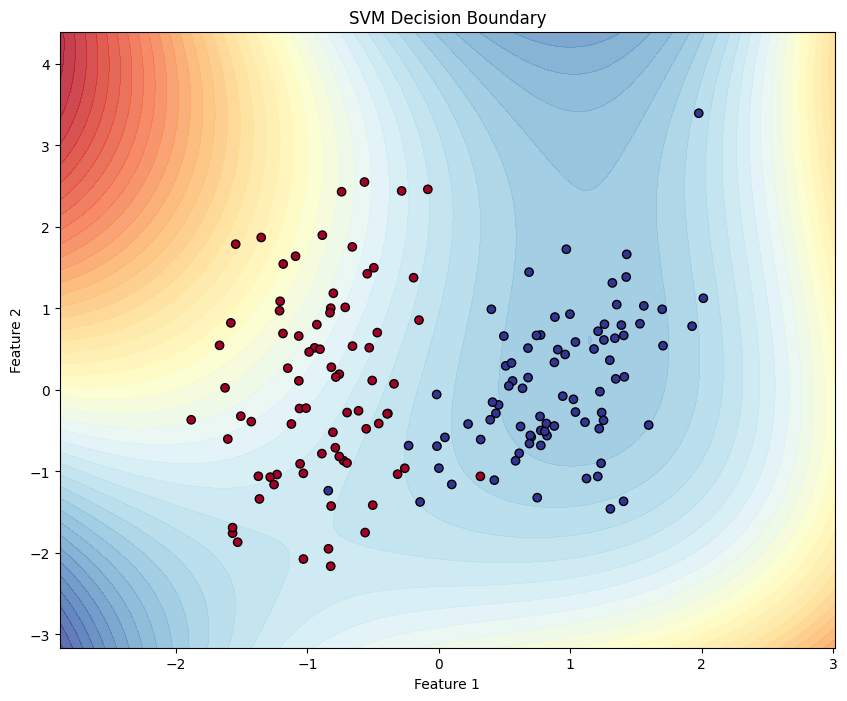

Training SVM with polynomial_kernel, param=3, C=10


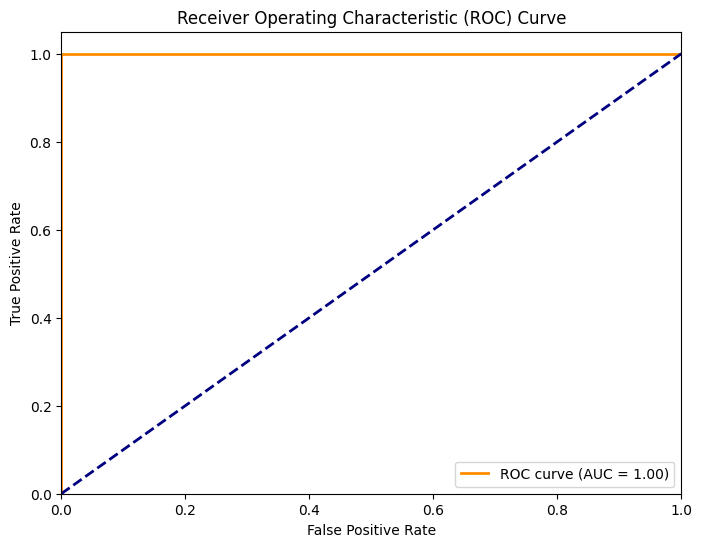

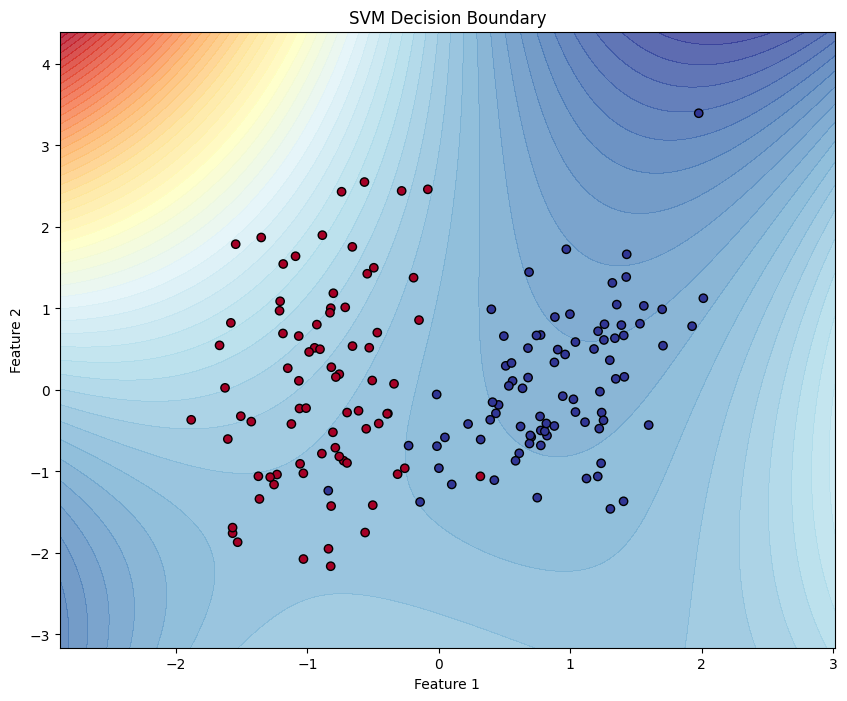

Training SVM with polynomial_kernel, param=4, C=0.1


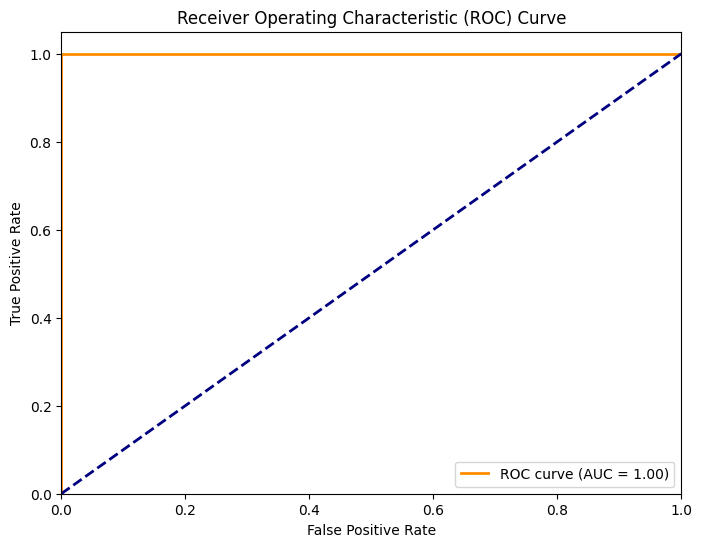

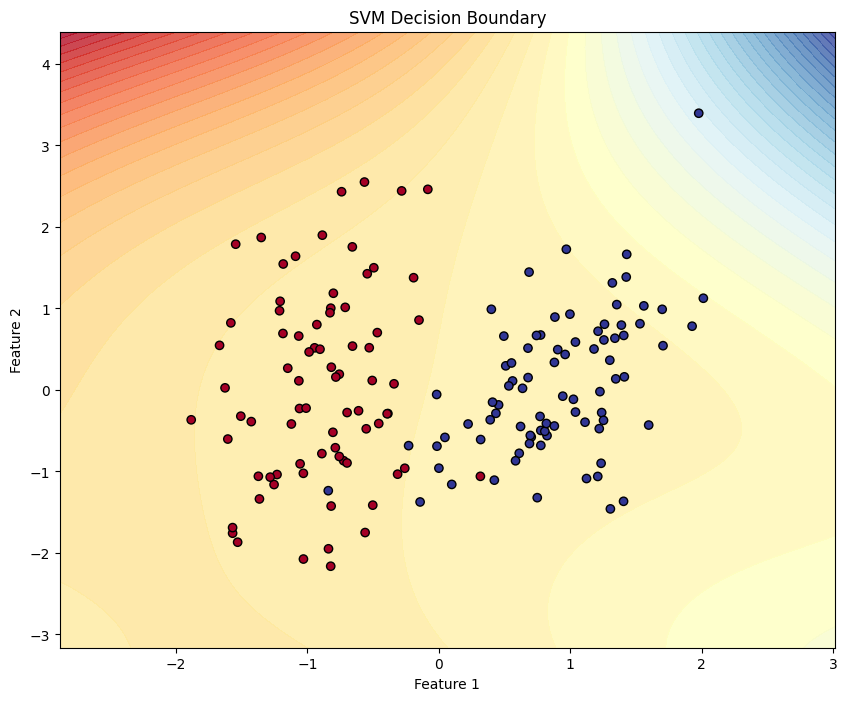

Training SVM with polynomial_kernel, param=4, C=0.5


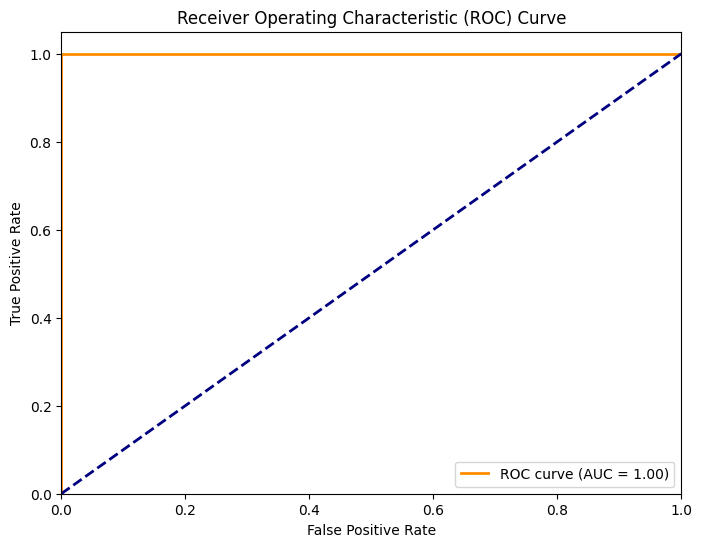

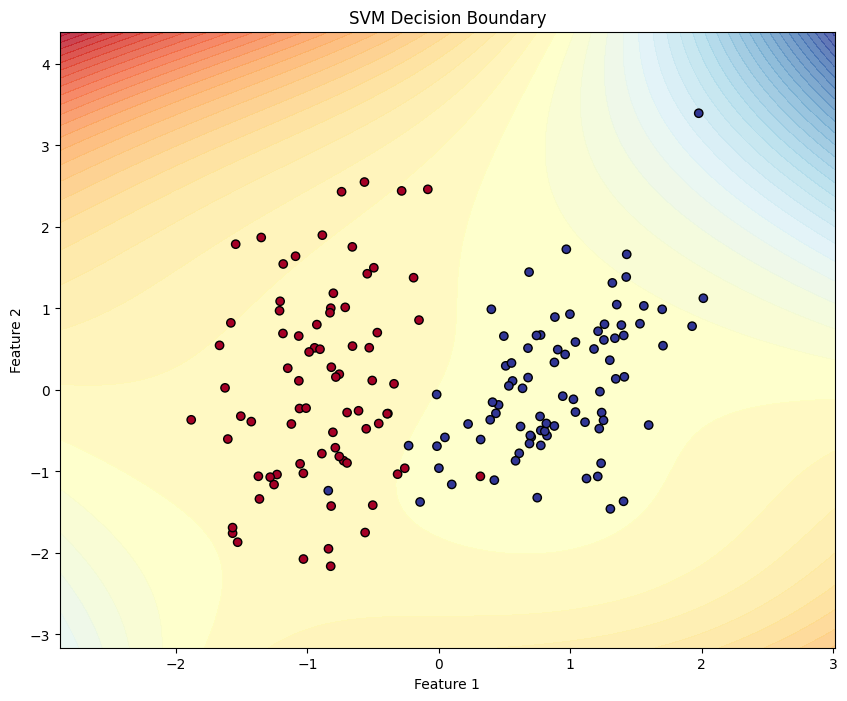

Training SVM with polynomial_kernel, param=4, C=1


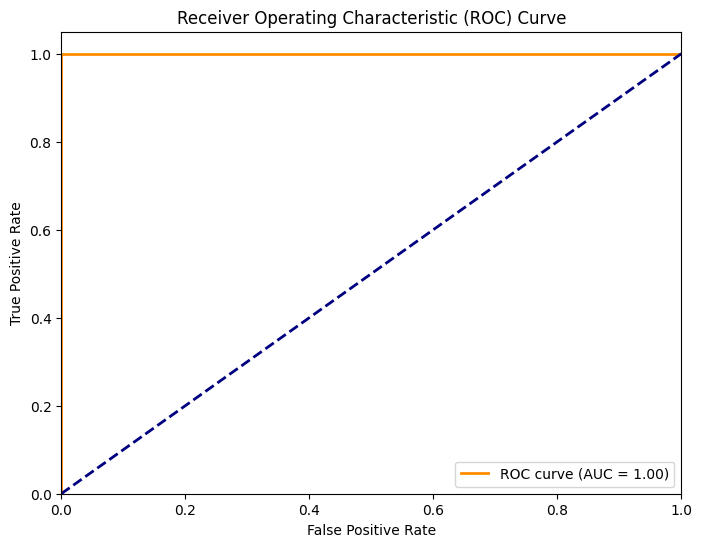

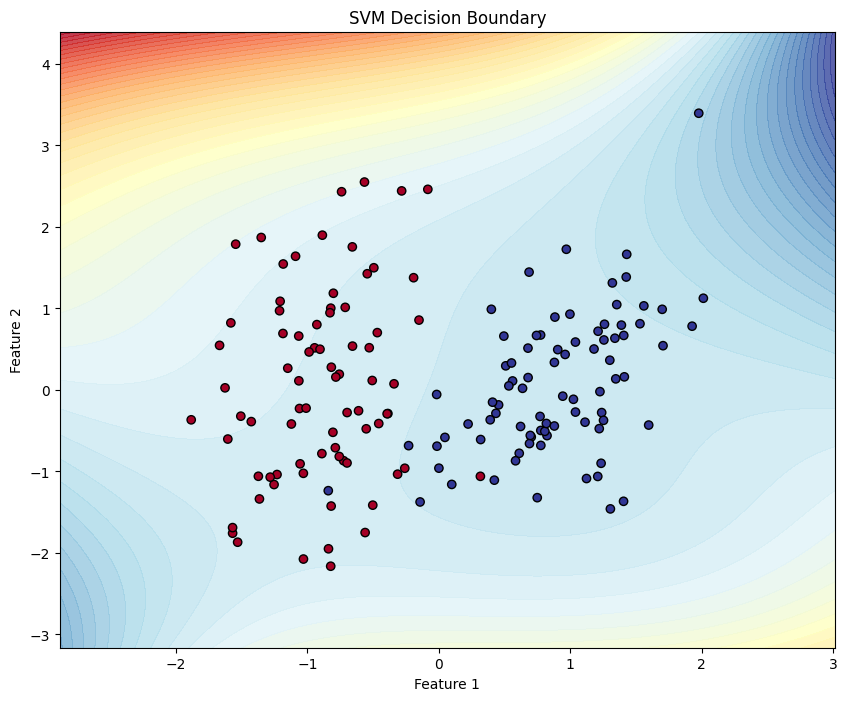

Training SVM with polynomial_kernel, param=4, C=5


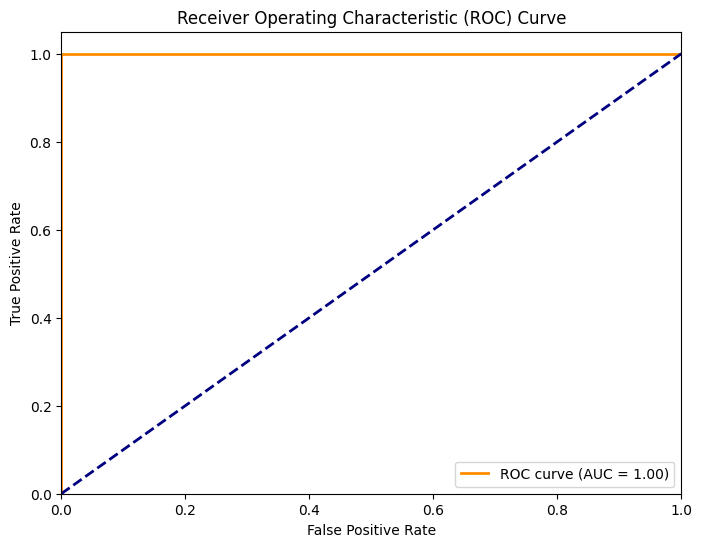

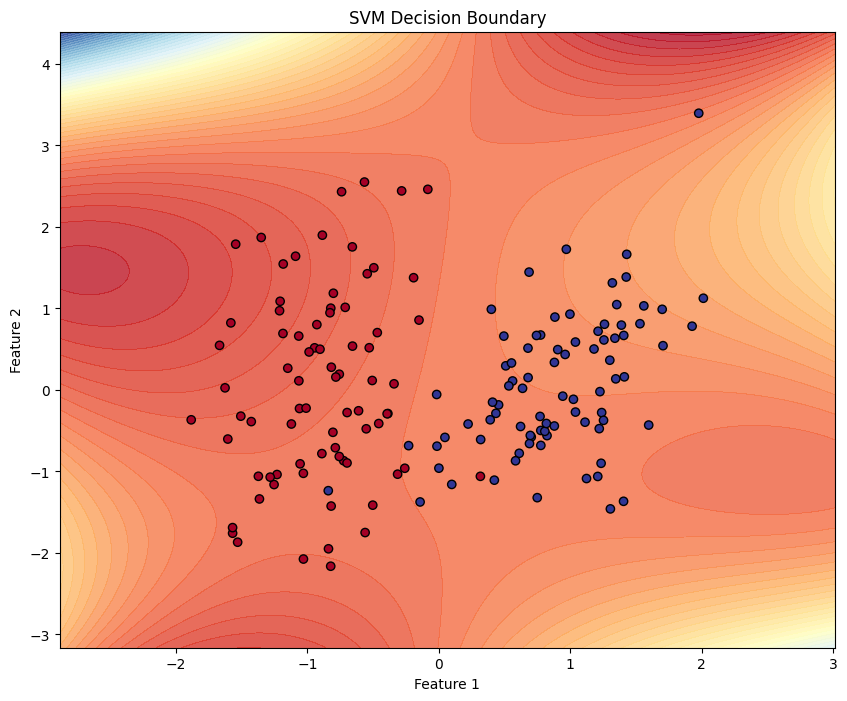

Training SVM with polynomial_kernel, param=4, C=10


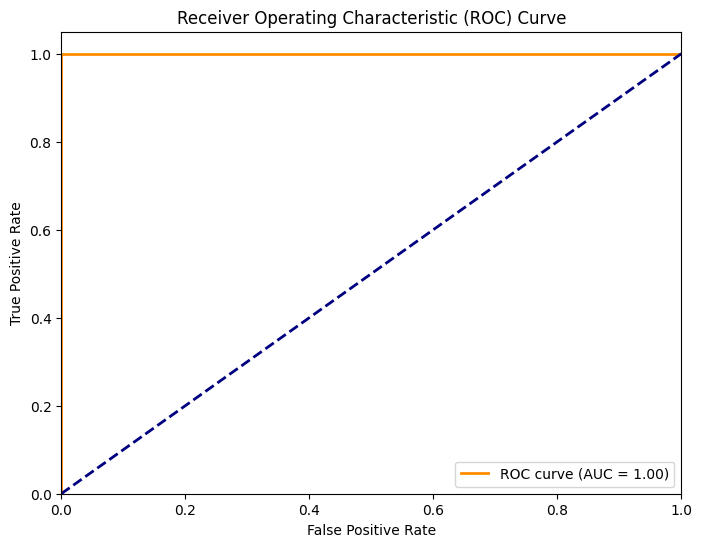

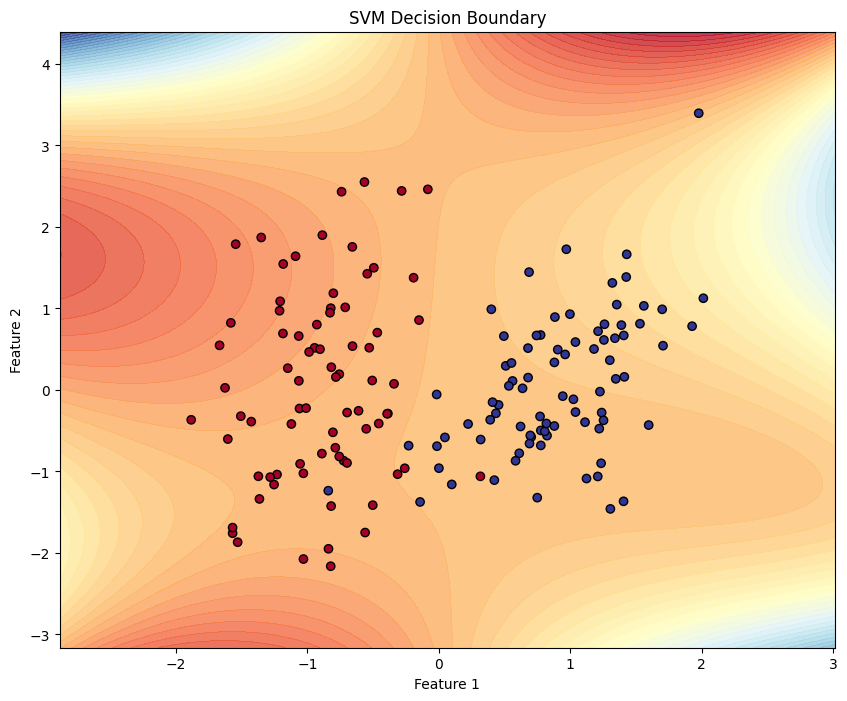

Kernel: rbf_kernel, Param: 0.05, C: 0.1
Training Accuracy: 97.50%
Testing Accuracy: 100.00%
ROC AUC: 1.0000
------------------------------
Kernel: rbf_kernel, Param: 0.05, C: 0.5
Training Accuracy: 97.50%
Testing Accuracy: 100.00%
ROC AUC: 1.0000
------------------------------
Kernel: rbf_kernel, Param: 0.05, C: 1
Training Accuracy: 97.50%
Testing Accuracy: 100.00%
ROC AUC: 1.0000
------------------------------
Kernel: rbf_kernel, Param: 0.05, C: 5
Training Accuracy: 98.12%
Testing Accuracy: 97.50%
ROC AUC: 1.0000
------------------------------
Kernel: rbf_kernel, Param: 0.05, C: 10
Training Accuracy: 98.12%
Testing Accuracy: 97.50%
ROC AUC: 1.0000
------------------------------
Kernel: rbf_kernel, Param: 0.1, C: 0.1
Training Accuracy: 97.50%
Testing Accuracy: 100.00%
ROC AUC: 1.0000
------------------------------
Kernel: rbf_kernel, Param: 0.1, C: 0.5
Training Accuracy: 97.50%
Testing Accuracy: 100.00%
ROC AUC: 1.0000
------------------------------
Kernel: rbf_kernel, Param: 0.1, C: 1

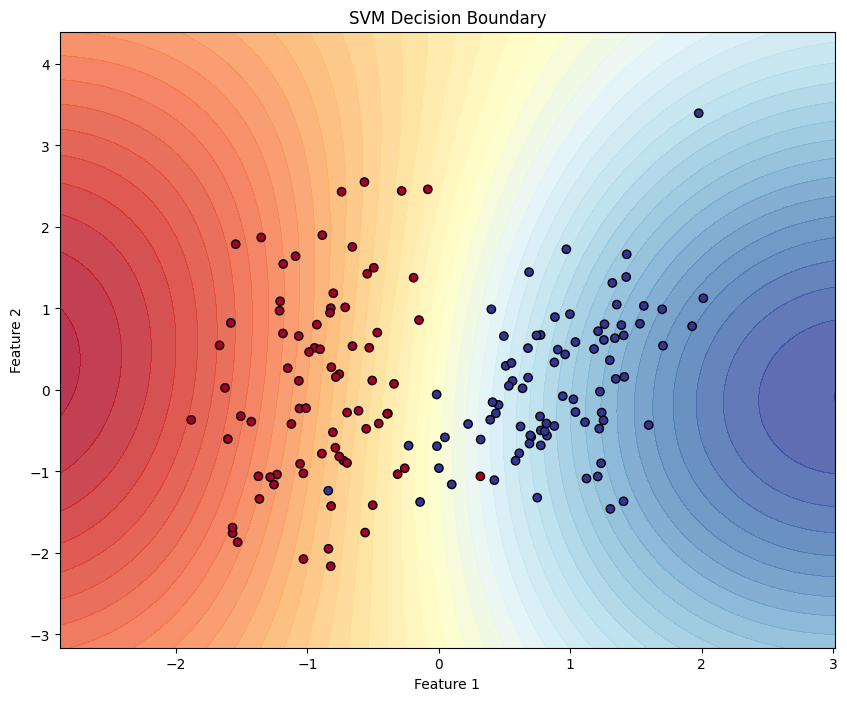

Classification Report:
               precision    recall  f1-score   support

          -1       1.00      1.00      1.00        23
           1       1.00      1.00      1.00        17

    accuracy                           1.00        40
   macro avg       1.00      1.00      1.00        40
weighted avg       1.00      1.00      1.00        40

Confusion Matrix:
 [[23  0]
 [ 0 17]]


In [16]:
gamma_values = [0.05, 0.1, 0.5, 1, 2, 5]
C_values = [0.1, 0.5, 1, 5, 10]
degree_values = [2, 3, 4]
results = []

for kernel_func in [rbf_kernel, polynomial_kernel]:
    param_values = gamma_values if kernel_func == rbf_kernel else degree_values
    for param in param_values:
        for C in C_values:
            print(f"Training SVM with {kernel_func.__name__}, param={param}, C={C}")
            alphas, b, support_vectors = train_svm(X_train, y_train, kernel_func, param, C)
            
            decision_function_train = decision_function(X_train, y_train, alphas, X_train, b, kernel_func, param)
            decision_function_test = decision_function(X_train, y_train, alphas, X_test, b, kernel_func, param)
            
            train_accuracy = np.mean(np.sign(decision_function_train) == y_train) * 100
            test_accuracy = np.mean(np.sign(decision_function_test) == y_test) * 100
            
            fpr, tpr, _ = roc_curve(y_test, decision_function_test)
            roc_auc = auc(fpr, tpr)
            
            results.append((kernel_func.__name__, param, C, train_accuracy, test_accuracy, roc_auc))
            
            plot_roc_curve(fpr, tpr, roc_auc)
            plot_decision_boundary(X_train, y_train, kernel_func, param, alphas, b)

for kernel, param, C, train_acc, test_acc, roc_auc in results:
    print(f"Kernel: {kernel}, Param: {param}, C: {C}")
    print(f"Training Accuracy: {train_acc:.2f}%")
    print(f"Testing Accuracy: {test_acc:.2f}%")
    print(f"ROC AUC: {roc_auc:.4f}")
    print("-" * 30)


Best Configuration:
Kernel: rbf_kernel, Param: 0.5, C: 10
Training Accuracy: 98.75%
Testing Accuracy: 100.00%
ROC AUC: 1.0000


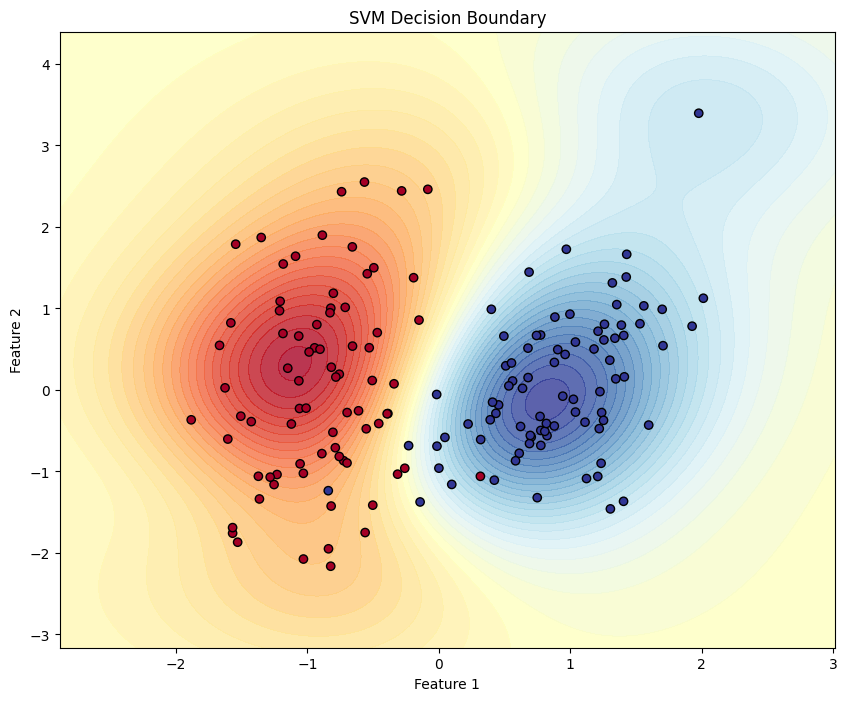

Classification Report:
               precision    recall  f1-score   support

          -1       1.00      1.00      1.00        23
           1       1.00      1.00      1.00        17

    accuracy                           1.00        40
   macro avg       1.00      1.00      1.00        40
weighted avg       1.00      1.00      1.00        40

Confusion Matrix:
 [[23  0]
 [ 0 17]]


In [18]:
best_config = max(results, key=lambda x: (x[4], x[3]))
print("Best Configuration:")
print(f"Kernel: {best_config[0]}, Param: {best_config[1]}, C: {best_config[2]}")
print(f"Training Accuracy: {best_config[3]:.2f}%")
print(f"Testing Accuracy: {best_config[4]:.2f}%")
print(f"ROC AUC: {best_config[5]:.4f}")

best_kernel = rbf_kernel if best_config[0] == 'rbf_kernel' else polynomial_kernel
best_param, best_C = best_config[1], best_config[2]
best_alphas, best_b, _ = train_svm(X_train, y_train, best_kernel, best_param, best_C)
plot_decision_boundary(X_train, y_train, best_kernel, best_param, best_alphas, best_b)

decision_values = decision_function(X_train, y_train, best_alphas, X_test, best_b, best_kernel, best_param)
y_pred = np.sign(decision_values)
print("Classification Report:\n", classification_report(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))